# Aula 3 - validação cruzada

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Validação cruzada (cross validation)
- 2) Ajuste de hiperparâmetros

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from ml_utils import *

____
____
____

## 1) Validação cruzada (cross validation)

O cross validation (CV) é uma das técnicas mais importantes no ferramental de um cientista de dados.

Operacionalmente, o CV implementa diferentes conjuntos de treino e teste (aqui chamados de **validação**), criando efetivamente diferentes modelos treinados e avaliados em diferentes suconjuntos aleatórios (os chamados **folds**) da base de dados original. 

No fim, é possível inspecionar as métricas de interesse em cada fold, bem como ter uma ideia da performance média do modelo, olhando para **a distribuição das métricas de avaliação**.

Note que este procedimento está intimamente relacionado com a avaliação da desejável habilidade de **generalização do modelo**!

A forma mais comum de fazermos CV é através da técnica **k-fold**:

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width=500>

No extremo desta abordagem, podemos tomar o número $k$ de folds igual ao número de observações na base ($n$). Neste caso, utiliza-se **uma única** observação para teste, enquanto o resto do dataset é utilizado para treino. Essa abordagem é conhecida como **leave one out (LOO)**:

<img src=https://assets.datacamp.com/production/repositories/3981/datasets/8a6236f142b1ee2e4a70aae2af9507c7c580f302/Screen%20Shot%202019-01-27%20at%209.25.41%20AM.png width=500>

Note que o esforço computacional aumenta conforme $k$ aumenta, sendo máximo quando $k=n$. Por esse motivo, recomenda-se usar o LOO apenas nos casos em que o número de observções na base original é bem pequeno ($\sim 10^2$).

Vamos implementar o procedimento de CV utilizando o sklearn!

No [submódulo model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), temos duas ferramentas muito importantes para o processo de CV:

- [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): classe que cria os folds. Obs.: para fazer o LOO, basta colocar $k=n$ folds, ou então usar diretamente a classe que implementa o [LOO](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut);

- [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate): função que recebe os folds e os utiliza para o treinamento e avaliação cruzada de modelos, segundo a métrica definida.

Para ilustrar o CV, vamos utilizar os datasets de regressão e classificação que já conhecemos!

_______

Vamos começar com nossa familiar base do problema de **regressão** (precificação de casas)

In [52]:
df = pd.read_csv("../datasets/house_prices.csv")

X = df.drop(columns=["Id", "SalePrice"])
y = df["SalePrice"]

# NÃO ESQUEÇA DO TRAIN-TEST SPLIT, MESMO NA VALIDAÇÃO CRUZADA!!!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_model = X_train.select_dtypes(include=np.number).dropna(axis="columns")
X_test_model = X_test.loc[:, X_train_model.columns]

In [5]:
X_train_model

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
254,20,8400,5,6,1957,1957,922,0,392,1314,...,294,250,0,0,0,0,0,0,6,2010
1066,60,7837,6,7,1993,1994,0,0,799,799,...,380,0,40,0,0,0,0,0,5,2009
638,30,8777,5,7,1910,1950,0,0,796,796,...,0,328,0,164,0,0,0,0,5,2008
799,50,7200,5,7,1937,1950,569,0,162,731,...,240,0,0,264,0,0,0,0,6,2007
380,50,5000,5,6,1924,1950,218,0,808,1026,...,308,0,0,242,0,0,0,0,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,9317,6,5,2006,2006,24,0,1290,1314,...,440,0,22,0,0,0,0,0,3,2007
1130,50,7804,4,3,1928,1950,622,0,500,1122,...,576,431,44,0,0,0,0,0,12,2009
1294,20,8172,5,7,1955,1990,167,0,697,864,...,572,0,0,0,0,0,0,0,4,2006
860,50,7642,7,8,1918,1998,0,0,912,912,...,216,0,240,0,0,0,0,0,6,2007


In [6]:
y_train

254     145000
1066    178000
638      85000
799     175000
380     127000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 1168, dtype: int64

Vamos usar o CV implementado do sklearn:

In [7]:
from sklearn.model_selection import KFold

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
vars(kf)

{'n_splits': 5, 'shuffle': True, 'random_state': 42}

Com o método `.split()`, podemos pegar os índices de cada split:

In [10]:
len(list(kf.split(X_train_model)))

5

In [11]:
list(kf.split(X_train_model))[0]

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          24,   25,   26,   27,   28,   29,   30,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   45,   46,   47,   48,
          50,   52,   53,   55,   57,   60,   61,   62,   64,   65,   66,
          67,   68,   69,   71,   72,   73,   74,   75,   77,   78,   79,
          80,   81,   82,   84,   85,   87,   89,   90,   91,   92,   93,
          94,   95,   97,   98,   99,  100,  102,  103,  104,  105,  106,
         108,  110,  111,  112,  114,  115,  116,  117,  118,  119,  120,
         121,  122,  123,  124,  125,  126,  127,  129,  130,  131,  132,
         133,  134,  136,  137,  142,  143,  144,  145,  146,  147,  148,
         149,  150,  151,  152,  153,  154,  157,  159,  160,  161,  162,
         164,  165,  166,  167,  169,  171,  172,  173,  175,  176,  177,
         178,  179,  180,  181,  182, 

Em cada split, temos uma tupla `([indices de treino], [indices de validação])`.

Como visto acima, isso é feito pra cada split. O que temos abaixo é apenas o primeiro split (indice 0):

In [12]:
idcs_train, idcs_val = list(kf.split(X_train_model))[0]

In [13]:
idcs_val

array([  10,   23,   31,   43,   44,   49,   51,   54,   56,   58,   59,
         63,   70,   76,   83,   86,   88,   96,  101,  107,  109,  113,
        128,  135,  138,  139,  140,  141,  155,  156,  158,  163,  168,
        170,  174,  192,  198,  199,  208,  209,  210,  218,  220,  231,
        233,  240,  243,  244,  247,  260,  265,  270,  274,  275,  290,
        292,  294,  296,  298,  299,  306,  308,  309,  319,  321,  323,
        327,  328,  336,  344,  352,  354,  355,  358,  361,  362,  371,
        376,  377,  380,  390,  394,  398,  405,  409,  411,  420,  422,
        423,  424,  425,  428,  429,  432,  435,  442,  451,  457,  462,
        465,  467,  477,  478,  486,  493,  497,  506,  513,  519,  532,
        533,  535,  538,  539,  543,  545,  548,  554,  558,  560,  561,
        570,  572,  585,  589,  590,  594,  596,  599,  605,  614,  618,
        629,  630,  636,  643,  666,  667,  689,  692,  694,  695,  706,
        712,  714,  721,  723,  728,  731,  732,  7

In [14]:
X_train_model.iloc[idcs_train, :]

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
254,20,8400,5,6,1957,1957,922,0,392,1314,...,294,250,0,0,0,0,0,0,6,2010
1066,60,7837,6,7,1993,1994,0,0,799,799,...,380,0,40,0,0,0,0,0,5,2009
638,30,8777,5,7,1910,1950,0,0,796,796,...,0,328,0,164,0,0,0,0,5,2008
799,50,7200,5,7,1937,1950,569,0,162,731,...,240,0,0,264,0,0,0,0,6,2007
380,50,5000,5,6,1924,1950,218,0,808,1026,...,308,0,0,242,0,0,0,0,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,9317,6,5,2006,2006,24,0,1290,1314,...,440,0,22,0,0,0,0,0,3,2007
1130,50,7804,4,3,1928,1950,622,0,500,1122,...,576,431,44,0,0,0,0,0,12,2009
1294,20,8172,5,7,1955,1990,167,0,697,864,...,572,0,0,0,0,0,0,0,4,2006
860,50,7642,7,8,1918,1998,0,0,912,912,...,216,0,240,0,0,0,0,0,6,2007


In [15]:
X_train_model.iloc[idcs_val, :]

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
1445,85,8400,6,5,1966,1966,187,627,0,814,...,240,0,0,252,0,0,0,0,5,2007
965,60,10237,6,5,2005,2007,0,0,783,783,...,393,0,72,0,0,0,0,0,7,2007
210,30,5604,5,6,1925,1950,468,0,396,864,...,0,0,0,96,0,0,0,0,4,2008
83,20,8892,5,5,1960,1960,0,0,1065,1065,...,461,74,0,0,0,0,0,0,7,2007
1274,50,5362,5,6,1910,2003,0,0,661,661,...,552,242,0,81,0,0,0,0,11,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,90,7136,6,6,1946,1950,484,0,495,979,...,492,0,0,0,0,0,0,0,8,2007
871,60,8750,6,5,1998,1998,505,0,299,804,...,523,0,77,0,0,0,0,0,6,2010
1238,20,13072,6,5,2005,2005,0,0,1141,1141,...,484,0,0,0,0,0,0,0,3,2006
466,20,10628,7,5,1970,1970,778,0,499,1277,...,526,0,0,0,0,176,0,0,4,2007


Como vimos acima, a classe KFold indica a estratégia de splits a ser usada, e o método `.split()` só gera os splits.

Mas, na prática, vamos usar a função `cross_validate()` pra geras as métricas de avaliação na validação cruzada, que tem o KFold como argumento!

In [16]:
from sklearn.model_selection import cross_validate

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
%%time

estimador = LinearRegression()
kf = KFold(n_splits=200, shuffle=True, random_state=42)

results_cv = cross_validate(estimator=estimador,
                               X=X_train_model, y=y_train,
                               cv=kf, scoring="neg_mean_absolute_error",
                               return_train_score=True)

# .abs() pra deixar as métricas positivas
results_cv_df = pd.DataFrame(results_cv).abs()

Wall time: 4.62 s


Usando o `n_jobs` pra paralelização

In [19]:
%%time

estimador = LinearRegression()
kf = KFold(n_splits=200, shuffle=True, random_state=42)

results_cv = cross_validate(estimator=estimador,
                               X=X_train_model, y=y_train,
                               cv=kf, scoring="neg_mean_absolute_error",
                               return_train_score=True,
                               n_jobs=-1)

# .abs() pra deixar as métricas positivas
results_cv_df = pd.DataFrame(results_cv).abs()

Wall time: 19.2 s


In [20]:
%%time

estimador = LinearRegression()
kf = KFold(n_splits=200, shuffle=True, random_state=42)

results_cv = cross_validate(estimator=estimador,
                               X=X_train_model, y=y_train,
                               cv=kf, scoring="neg_mean_absolute_error",
                               return_train_score=True,
                               n_jobs=-1,
                               verbose=10)

# .abs() pra deixar as métricas positivas
results_cv_df = pd.DataFrame(results_cv).abs()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0450s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    4.2s


Wall time: 4.6 s


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished


___________

In [21]:
results_cv

{'fit_time': array([0.00903058, 0.01507235, 0.01653719, 0.00699782, 0.00799465,
        0.00903869, 0.0189898 , 0.01003218, 0.01099133, 0.012995  ,
        0.00999141, 0.01997519, 0.01998568, 0.01799583, 0.09594274,
        0.00899863, 0.0119946 , 0.0059979 , 0.01399207, 0.01499128,
        0.01199198, 0.02099156, 0.00599599, 0.01299238, 0.00699663,
        0.01199389, 0.01199245, 0.02406788, 0.01251197, 0.01299214,
        0.01996255, 0.04999256, 0.01799035, 0.01299214, 0.01999068,
        0.00999546, 0.03897882, 0.01399136, 0.03397942, 0.00999761,
        0.01699233, 0.01399159, 0.00899458, 0.00699687, 0.010993  ,
        0.0049963 , 0.00599957, 0.00999451, 0.01550126, 0.00800252,
        0.00999427, 0.0079968 , 0.00999427, 0.00699639, 0.00899744,
        0.01099396, 0.00999832, 0.01197338, 0.00751233, 0.01507306,
        0.02201915, 0.02099228, 0.01799035, 0.00999403, 0.06996012,
        0.02498245, 0.02898479, 0.00799513, 0.0059998 , 0.00899506,
        0.01099062, 0.01498842, 0.00

Vamos olhar pros resultados mais de perto...

In [22]:
results_cv_df

,fit_time,score_time,test_score,train_score
0,0.009031,0.009042,20258.064533,21070.040107
1,0.015072,0.004002,11933.599409,21110.962155
2,0.016537,0.011035,26508.616455,21062.847006
3,0.006998,0.005996,21384.480294,21069.696999
4,0.007995,0.003998,28063.462212,21018.460952
...,...,...,...,...
195,0.009994,0.005111,16064.454649,21083.565352
196,0.011033,0.002999,16838.983821,21078.877950
197,0.012110,0.005997,18996.192434,21060.210180
198,0.017991,0.003999,10830.182069,21111.000763


Vamos criar uma função:


In [23]:
def calc_cv(estimator, X, y, n_splits, scoring):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results_cv = cross_validate(estimator=estimador,
                                X=X, y=y,
                                cv=kf, scoring=scoring,
                                return_train_score=True)

    # .abs() pra deixar as métricas positivas
    results_cv_df = pd.DataFrame(results_cv).abs()
    
    return results_cv_df

In [24]:
results_cv_df = calc_cv(estimator=LinearRegression(), 
                        X=X_train_model, y=y_train, n_splits=10, scoring="neg_mean_absolute_error")

results_cv_df

,fit_time,score_time,test_score,train_score
0,0.008991,0.002999,20909.269814,21372.138145
1,0.012990,0.006999,21523.511964,21218.092027
2,0.007994,0.003998,21251.665323,21320.679994
3,0.005996,0.002998,23936.132206,20540.633686
4,0.004997,0.002998,21453.803482,21294.997170
5,0.009993,0.004998,26698.288474,19765.228481
6,0.005996,0.001997,22488.878462,21146.145270
7,0.007994,0.001000,22775.774380,21076.303238
8,0.004996,0.001999,19292.448322,21512.516230
9,0.005996,0.002000,20629.538473,21345.526953


In [25]:
results_cv_df[["test_score", "train_score"]].describe()

,test_score,train_score
count,10.000000,10.000000
mean,22095.931090,21059.226119
std,2056.301758,525.542374
min,19292.448322,19765.228481
25%,20994.868691,21093.763746
50%,21488.657723,21256.544599
75%,22704.050400,21339.315213
max,26698.288474,21512.516230


<AxesSubplot:xlabel='test_score', ylabel='Count'>

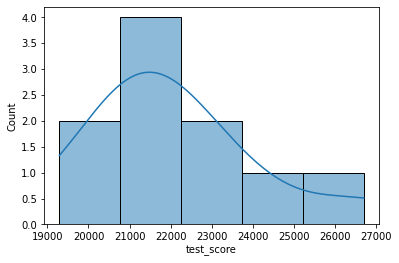

In [26]:
sns.histplot(data=results_cv_df, x="test_score", kde=True)

<AxesSubplot:xlabel='train_score', ylabel='Count'>

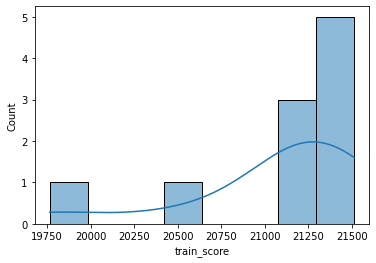

In [27]:
sns.histplot(data=results_cv_df, x="train_score", kde=True)

<AxesSubplot:xlabel='train_score', ylabel='Count'>

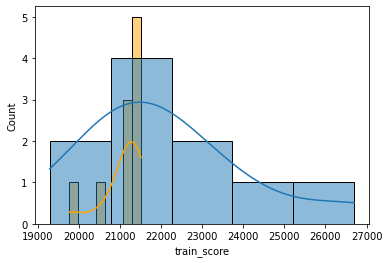

In [28]:
sns.histplot(data=results_cv_df, x="train_score", kde=True, color="orange")
sns.histplot(data=results_cv_df, x="test_score", kde=True)

In [29]:
def calc_cv(estimator, X, y, n_splits, scoring, plot_distros=False):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results_cv = cross_validate(estimator=estimador,
                                X=X, y=y,
                                cv=kf, scoring=scoring,
                                return_train_score=True)

    # .abs() pra deixar as métricas positivas
    results_cv_df = pd.DataFrame(results_cv).abs()
    
    # ================================================
    
    print("Distribuição de métricas de avaliação:")
    
    display(results_cv_df[["test_score", "train_score"]].describe())
    
    # ================================================
    
    if plot_distros:
        
        print("\nDistribuição de métricas de treino")
        sns.histplot(data=results_cv_df, x="train_score", kde=True, color="orange")
        plt.show()

        print("\nDistribuição de métricas de teste")
        sns.histplot(data=results_cv_df, x="test_score", kde=True)
        plt.show()

        print("\nAs duas juntas (compara a variância!)")
        sns.histplot(data=results_cv_df, x="train_score", kde=True, color="orange", label="treino")
        sns.histplot(data=results_cv_df, x="test_score", kde=True, label="teste")
        plt.legend()
        plt.show()
    
    # ================================================
    
    return results_cv_df

Distribuição de métricas de avaliação:


,test_score,train_score
count,10.000000,10.000000
mean,22095.931090,21059.226119
std,2056.301758,525.542374
min,19292.448322,19765.228481
25%,20994.868691,21093.763746
50%,21488.657723,21256.544599
75%,22704.050400,21339.315213
max,26698.288474,21512.516230



Distribuição de métricas de treino


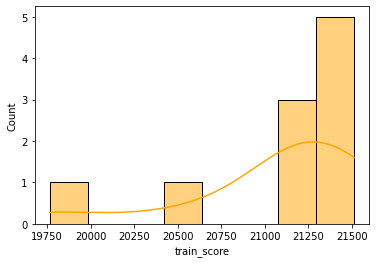


Distribuição de métricas de teste


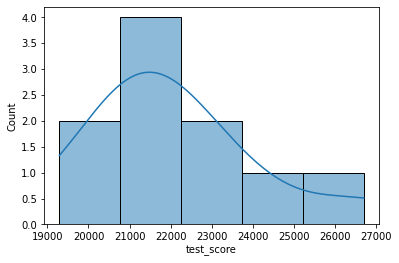


As duas juntas (compara a variância!)


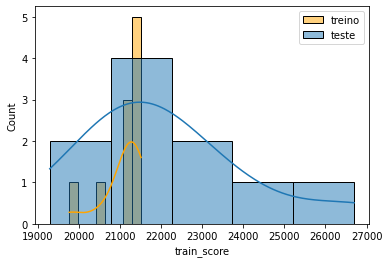

In [30]:
_ = calc_cv(estimator=LinearRegression(), 
            X=X_train_model, y=y_train, n_splits=10, scoring="neg_mean_absolute_error", plot_distros=True)

Caso queira usar mais métricas de uma vez... SEM PROBLEMAS :)

In [31]:
estimador = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2")

results_cv = cross_validate(estimator=estimador,
                               X=X_train_model, y=y_train,
                               cv=kf, scoring=scoring,
                               return_train_score=True)

# .abs() pra deixar as métricas positivas
results_cv_df = pd.DataFrame(results_cv).abs()

results_cv_df.columns.tolist()

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'train_neg_mean_absolute_error',
 'test_neg_root_mean_squared_error',
 'train_neg_root_mean_squared_error',
 'test_r2',
 'train_r2']

Se eu simplesmente usar a função como acima, vai dar um erro devido aos muitos scores que temos agora!!!

In [32]:
## descomente, caso queira ver o erro!

# _ = calc_cv(estimator=LinearRegression(), 
#             X=X_train_model, y=y_train, n_splits=10, 
#             scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"),
#             plot_distros=True)

Adaptando a função:

In [33]:
def extrai_nome_metrica(str_metrica):
    '''
    - str_metrica: alguma string de metrica do sklearn, que sai do cross_validate com o prefixo "train_" ou "test_"
    (veja aqui os exemplos: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
    
    - type_metric: "train_" ou "test_", dependendo do que temos
    '''
    
    type_metric = str_metrica.split("_")[0] + "_"
    
    return str_metrica.split(type_metric)[-1].replace("neg_", "").replace("_", " ")


Distribuição da métrica de avaliação mean absolute error:


,test_neg_mean_absolute_error,train_neg_mean_absolute_error
count,5.000000,5.000000
mean,22402.774513,21072.347663
std,1316.479502,778.323963
min,20521.754441,19887.554681
25%,21666.364138,20814.936385
50%,22691.260077,21170.573062
75%,23398.842213,21602.263215
max,23735.651696,21886.410970



Distribuição de mean absolute error de treino


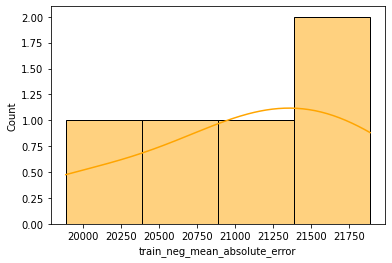


Distribuição de mean absolute error de teste


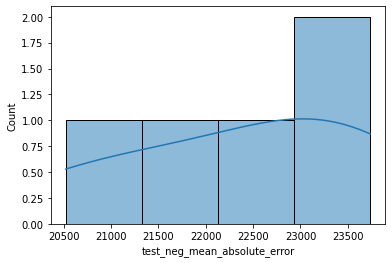


As duas juntas (compara a variância!)


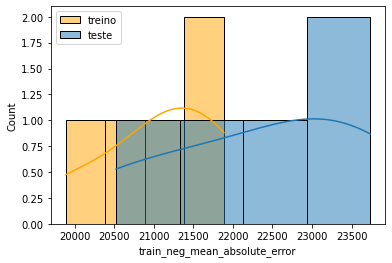

################################################################################

Distribuição da métrica de avaliação root mean squared error:


,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
count,5.000000,5.000000
mean,36793.293742,33835.745700
std,8641.698242,2115.490913
min,28685.883135,30435.381888
25%,32586.660387,33175.025513
50%,32727.060938,34875.878812
75%,39300.169837,34987.589736
max,50666.694412,35704.852552



Distribuição de root mean squared error de treino


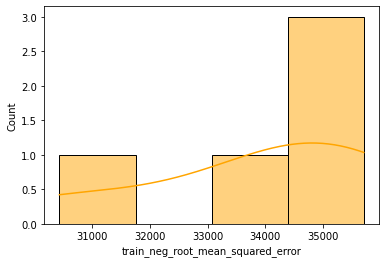


Distribuição de root mean squared error de teste


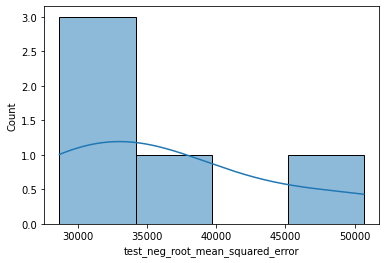


As duas juntas (compara a variância!)


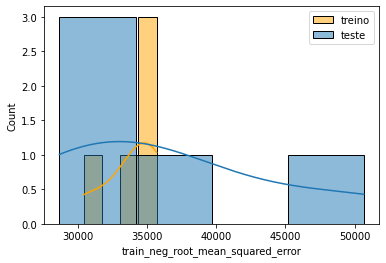

################################################################################

Distribuição da métrica de avaliação r2:


,test_r2,train_r2
count,5.000000,5.000000
mean,0.767744,0.807702
std,0.093329,0.020297
min,0.618834,0.791676
25%,0.736132,0.792242
50%,0.805443,0.798958
75%,0.834299,0.816274
max,0.844014,0.839359



Distribuição de r2 de treino


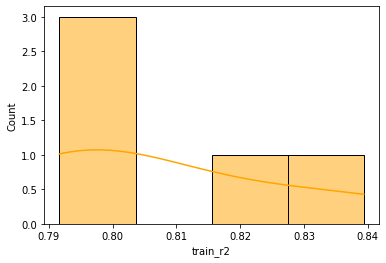


Distribuição de r2 de teste


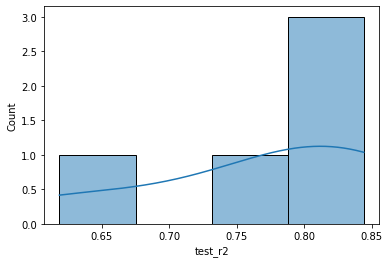


As duas juntas (compara a variância!)


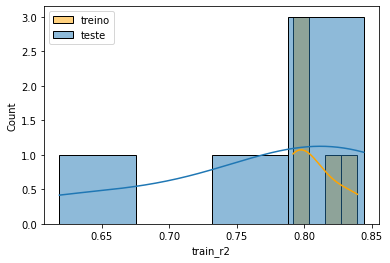

################################################################################


In [34]:
colunas_metricas = results_cv_df.columns.tolist()[2:]

for i in range(0, len(colunas_metricas), 2):
    
    # colunas de teste e treino
    col_test, col_train = colunas_metricas[i], colunas_metricas[i+1]
        
    # estrai o "test_", e dá apenas a string referente à metrica (sem o underline!!)
    str_metrica = extrai_nome_metrica(col_test)

    print(f"\nDistribuição da métrica de avaliação {str_metrica}:")
    
    display(results_cv_df[[col_test, col_train]].describe())
    
    print(f"\nDistribuição de {str_metrica} de treino")
    sns.histplot(data=results_cv_df, x=col_train, kde=True, color="orange")
    plt.show()

    print(f"\nDistribuição de {str_metrica} de teste")
    sns.histplot(data=results_cv_df, x=col_test, kde=True)
    plt.show()

    print("\nAs duas juntas (compara a variância!)")
    sns.histplot(data=results_cv_df, x=col_train, kde=True, color="orange", label="treino")
    sns.histplot(data=results_cv_df, x=col_test, kde=True, label="teste")
    plt.legend()
    plt.show()
    
    print("#"*80)

Entendida a construção acima, vamos pra função:

In [50]:
def calc_cv(estimator, X, y, n_splits, scoring, n_jobs=-1, verbose=10, plot_distros=False):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    results_cv = cross_validate(estimator=estimator,
                                X=X, y=y,
                                cv=kf, scoring=scoring,
                                return_train_score=True,
                                n_jobs=n_jobs, 
                                verbose=verbose)

    # .abs() pra deixar as métricas positivas
    results_cv_df = pd.DataFrame(results_cv).abs()
    
    # ================================================
    
    colunas_metricas = results_cv_df.columns.tolist()[2:]

    for i in range(0, len(colunas_metricas), 2):

        # colunas de teste e treino
        col_test, col_train = colunas_metricas[i], colunas_metricas[i+1]

        # estrai o "test_", e dá apenas a string referente à metrica (sem o underline!!)
        str_metrica = extrai_nome_metrica(col_test)

        print(f"\nDistribuição da métrica de avaliação {str_metrica}:")

        display(results_cv_df[[col_test, col_train]].describe())
        
        # ================================================

        if plot_distros:
            
            print(f"\nDistribuição de {str_metrica} de treino")
            sns.histplot(data=results_cv_df, x=col_train, kde=True, color="orange")
            plt.show()

            print(f"\nDistribuição de {str_metrica} de teste")
            sns.histplot(data=results_cv_df, x=col_test, kde=True)
            plt.show()

            print("\nAs duas juntas (compara a variância!)")
            sns.histplot(data=results_cv_df, x=col_train, kde=True, color="orange", label="treino")
            sns.histplot(data=results_cv_df, x=col_test, kde=True, label="teste")
            plt.legend()
            plt.show()

        print("#"*80)
    
    # ================================================
    
    return results_cv_df

In [53]:
_ = calc_cv(estimator=LinearRegression(), 
            X=X_train_model, y=y_train, n_splits=20, 
            scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"),
            plot_distros=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0600s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s



Distribuição da métrica de avaliação mean absolute error:


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


,test_neg_mean_absolute_error,train_neg_mean_absolute_error
count,20.000000,20.000000
mean,22399.581016,21052.008916
std,3172.435943,278.638159
min,16313.681063,20063.295735
25%,21010.988793,20970.839118
50%,22210.768535,21103.084783
75%,23333.148693,21223.224998
max,29772.699285,21412.571326


################################################################################

Distribuição da métrica de avaliação root mean squared error:


,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
count,20.000000,20.000000
mean,36733.301638,34095.204700
std,16692.073882,927.796005
min,20808.560860,30833.666967
25%,27699.716056,34099.980640
50%,31437.743922,34419.467035
75%,37976.415587,34568.922366
max,89462.322496,34824.185022


################################################################################

Distribuição da métrica de avaliação r2:


,test_r2,train_r2
count,20.000000,20.000000
mean,0.830713,0.804912
std,0.192734,0.010387
min,0.497639,0.797680
25%,0.761789,0.799719
50%,0.844060,0.801384
75%,0.863993,0.805065
max,1.511230,0.844380


################################################################################


In [37]:
# isso é um protótipo (bem alto nivel) do intervalo de confiança pra media
# mas lembre-se: há detalhes adicionais! lembre das aulas de estatistico!

22399.581016 - 1.96*(3172.435943/np.sqrt(30)), 22399.581016 + 1.96*(3172.435943/np.sqrt(30))

(21264.339393562102, 23534.822638437898)

Lição de casa: construa os intervalos de confiança "direito" (cheque as condições do TCL, calcule o $z_{\alpha/2}$ (ou $t_{\alpha/2}$) adequados, etc.)

In [38]:
# PRA CASA: intervalos de confiança!

Mas, e daí? Como interpretamos isso acima?

Vamos treinar o modelo com **todo** os dados de treino (ou seja, dessa vez, sem os splits), e depois calcular as métricas de avaliação, como fazíamos antes! (aqui entra a base de teste!)

In [39]:
model = LinearRegression().fit(X_train_model, y_train)

_ = calc_reg_metrics(model, X_train_model, y_train, label="treino", plot=False, dist_resids=False, print_stuff=True)

print("\n")

_ = calc_reg_metrics(model, X_test_model, y_test, label="teste", plot=False, dist_resids=False, print_stuff=True)


Métricas de avaliação (dados de treino):

R^2: 0.80
MAE: 21054.72
RMSE: 34241.17
MAPE: 12.42%



Métricas de avaliação (dados de teste):

R^2: 0.82
MAE: 22938.25
RMSE: 37312.27
MAPE: 13.45%


_______________

____

**Na prática**:

Para bases maiores, nós fazemos realmente como está na figura lá em cima, isto é:

- primeiro fazemos o train-test split;
- aí, aplicamos CV na base de treino;
- depois testamos na base de teste

Isso é sobretudo importante no segundo "uso" do cv, que é otimização de hiperparâmetros, como veremos mais à frente!

Mas, quando tivermos bases muito pequenas ($\sim 10^2$ linhas), o train-test split pode não ser possível, e, nesse caso, trabalhamos apenas com as métricas da validação cruzada!

_____

Vamos agora ver um caso de **classificação**:

In [54]:
df = pd.read_csv("../datasets/advertising.csv")

df_model = df.select_dtypes(include=np.number)

X = df_model.drop(columns="Clicked on Ad")
y = df_model["Clicked on Ad"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##################################

# vamos escalar pq vamos usar regularização!
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(X_train)

X_train_adv_mms, X_test_adv_mms = mms.transform(X_train), mms.transform(X_test)

Agora, o CV, bem parecido com o que fizemos acima:

- uma regressão logística com regularização l1 e fator de regularização (C) igual a 1.2;
- 10 folds;
- roc_auc como métrica de avaliação.

In [55]:
from sklearn.linear_model import LogisticRegression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0490s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s



Distribuição da métrica de avaliação f1 weighted:


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


,test_f1_weighted,train_f1_weighted
count,20.000000,20.000000
mean,0.971427,0.972398
std,0.027830,0.002027
min,0.914145,0.969913
25%,0.964178,0.971044
50%,0.971548,0.972172
75%,1.000000,0.974422
max,1.000000,0.975933



Distribuição de f1 weighted de treino


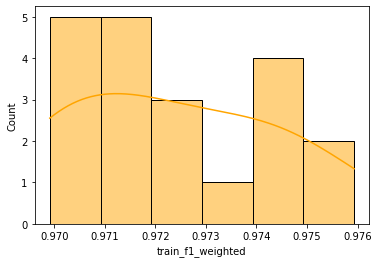


Distribuição de f1 weighted de teste


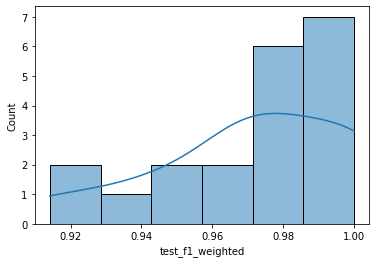


As duas juntas (compara a variância!)


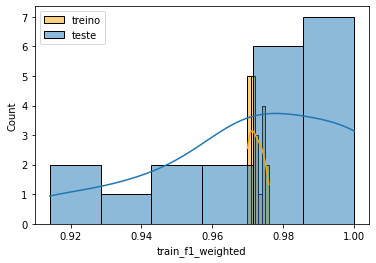

################################################################################

Distribuição da métrica de avaliação roc auc:


,test_roc_auc,train_roc_auc
count,20.000000,20.000000
mean,0.991055,0.992520
std,0.016330,0.000659
min,0.950000,0.992030
25%,0.993397,0.992127
50%,0.996667,0.992207
75%,1.000000,0.992509
max,1.000000,0.994129



Distribuição de roc auc de treino


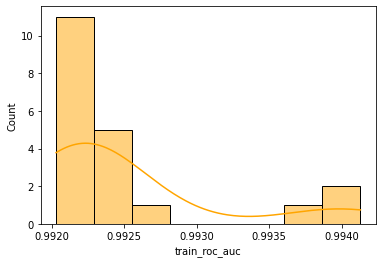


Distribuição de roc auc de teste


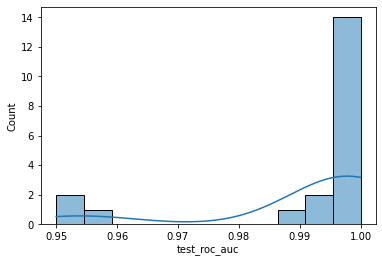


As duas juntas (compara a variância!)


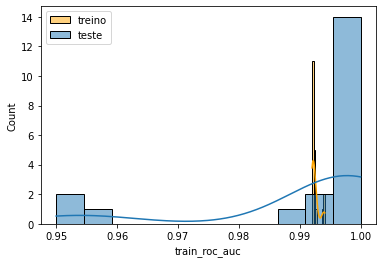

################################################################################


In [57]:
# lembre-se de adequas as métricas em scoring pro tipo de problema que estamos resolvendo!

_ = calc_cv(estimator=LogisticRegression(penalty="l1", C=1.2, solver="liblinear"), 
            X=X_train_adv_mms, y=y_train, n_splits=20, 
            scoring=("f1_weighted", "roc_auc"),
            plot_distros=True, verbose=10)

Métricas de avaliação de treino - com cutoff = 0.50


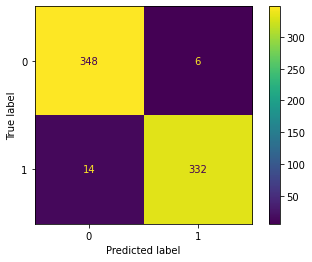

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       354
           1       0.98      0.96      0.97       346

    accuracy                           0.97       700
   macro avg       0.97      0.97      0.97       700
weighted avg       0.97      0.97      0.97       700

                      Abaixo, métricas que variam o cutoff                      
                               Classe positiva: 1                               


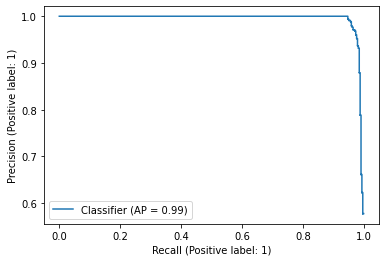

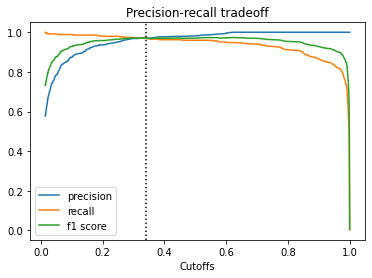

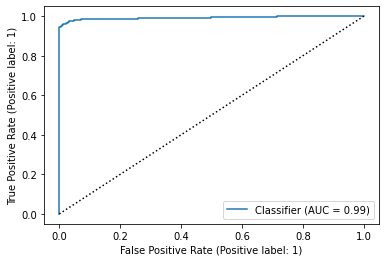

Métricas de avaliação de treino - com cutoff = 0.50


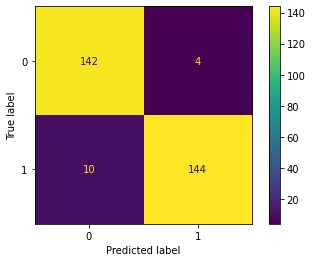

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       146
           1       0.97      0.94      0.95       154

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300

                      Abaixo, métricas que variam o cutoff                      
                               Classe positiva: 1                               


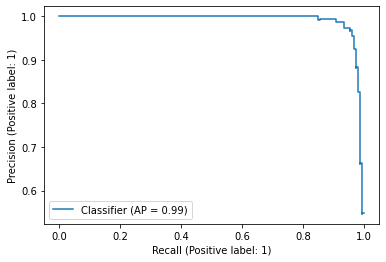

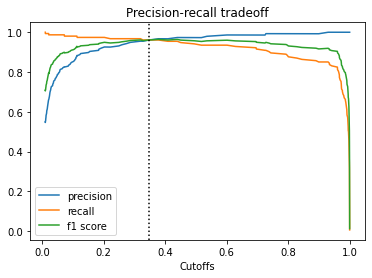

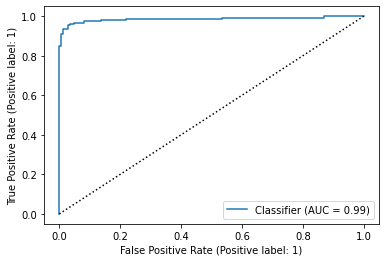

{'0': {'precision': 0.9342105263157895,
  'recall': 0.9726027397260274,
  'f1-score': 0.9530201342281879,
  'support': 146},
 '1': {'precision': 0.972972972972973,
  'recall': 0.935064935064935,
  'f1-score': 0.9536423841059603,
  'support': 154},
 'accuracy': 0.9533333333333334,
 'macro avg': {'precision': 0.9535917496443813,
  'recall': 0.9538338373954812,
  'f1-score': 0.9533312591670741,
  'support': 300},
 'weighted avg': {'precision': 0.9541085822664771,
  'recall': 0.9533333333333334,
  'f1-score': 0.9533395558321112,
  'support': 300}}

In [59]:
modelo = LogisticRegression(penalty="l1", C=1.2, solver="liblinear").fit(X_train_adv_mms, y_train)
    
clf_metrics(modelo, X_train_adv_mms, y_train, cutoff=0.5, label_metrica="treino", 
            print_plot=True, plot_conf_matrix=True, print_cr=True,
            plot_prc=True, plot_roc=True, pos_label=1)

clf_metrics(modelo, X_test_adv_mms, y_test, cutoff=0.5, label_metrica="treino", 
            print_plot=True, plot_conf_matrix=True, print_cr=True,
            plot_prc=True, plot_roc=True, pos_label=1)

____________

## 2) Ajuste de hiperparâmetros

Além de permitir uma avaliação mais robusta de um modelo, o CV pode também ser utilizado para um propósito muito importante: **a escolha de valores adequados de hiperparâmetros** de um modelo -- processo conhecido como **hyperparameter tuning**.

<img src=https://www.okw.com/en/Com-Knobs/COM-KNOBS-class-OKW_GroupInfoImage500x408.jpg width=400>

Na aula que vem vamos estudar uma forma mais estruturada de fazer este procedimento.

Mas, nesta aula, vamos ver formas automáticas e diretas de aplicar CV aos modelos que conhecemos!

Antes de irmos pra prática, uma pergunta importante é: **como/por que utilizar CV para o ajuste de hiperparâmetros?**

Ao testarmos diferentes valores/combinações de hiperparâmetros em diferentes folds, temos uma estimativa mais realista sobre o efeito destas escolhas: se o resultado for bom em todos os folds (ou bom em média), temos um indicativo mais robusto de que de fato aquela é uma boa escolha. Em particular, fica muito mais difícil de cometermos **overfitting** através da escolha de hiperparâmetros que ajustem muito bem uma única base de treino. Faz sentido, né?

Para saber mais sobre estas questões, sugiro [este post](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) e [este post](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).

No sklearn, temos o procedimento de CV incorporado a algumas classes de hipóteses:

- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
- [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Em todos os casos, é possível especificar uma lista de hiperparâmetros a serem percorridos, e o modelo com melhor hiperparâmetro (ou combinação de hiperparâmetros) é escolhido! 

Vamos pegar as bases acima e aplicar os métodos de CV built-in pra ver se encontramos resultados melhores:

In [61]:
df = pd.read_csv("../datasets/house_prices.csv")

X = df.drop(columns=["Id", "SalePrice"])
y = df["SalePrice"]

# NÃO ESQUEÇA DO TRAIN-TEST SPLIT, MESMO NA VALIDAÇÃO CRUZADA!!!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_model = X_train.select_dtypes(include=np.number).dropna(axis="columns")
X_test_model = X_test.loc[:, X_train_model.columns]

###########################################

mms = MinMaxScaler().fit(X_train_model)

X_train_hp_mms, X_test_hp_mms = mms.transform(X_train_model), mms.transform(X_test_model)

In [63]:
np.linspace(0.1, 100, 100)

array([  0.1       ,   1.10909091,   2.11818182,   3.12727273,
         4.13636364,   5.14545455,   6.15454545,   7.16363636,
         8.17272727,   9.18181818,  10.19090909,  11.2       ,
        12.20909091,  13.21818182,  14.22727273,  15.23636364,
        16.24545455,  17.25454545,  18.26363636,  19.27272727,
        20.28181818,  21.29090909,  22.3       ,  23.30909091,
        24.31818182,  25.32727273,  26.33636364,  27.34545455,
        28.35454545,  29.36363636,  30.37272727,  31.38181818,
        32.39090909,  33.4       ,  34.40909091,  35.41818182,
        36.42727273,  37.43636364,  38.44545455,  39.45454545,
        40.46363636,  41.47272727,  42.48181818,  43.49090909,
        44.5       ,  45.50909091,  46.51818182,  47.52727273,
        48.53636364,  49.54545455,  50.55454545,  51.56363636,
        52.57272727,  53.58181818,  54.59090909,  55.6       ,
        56.60909091,  57.61818182,  58.62727273,  59.63636364,
        60.64545455,  61.65454545,  62.66363636,  63.67

In [70]:
from sklearn.linear_model import LassoCV

kf = KFold(n_splits=10, shuffle=True, random_state=42)

lasso_cv = LassoCV(alphas=np.linspace(0.1, 100, 100),
                   cv=kf,
                   n_jobs=-1, 
                   verbose=10, 
                   max_iter=1000).fit(X_train_hp_mms, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


(array([-29027.29776118,  53813.49835433, 178565.72686382,  19176.24924432,
        37868.1808294 ,  14977.78151631,  41198.3735159 ,     -0.        ,
            0.        ,   8017.00906107,  14153.37858393,      0.        ,
           -0.        , 216769.951432  ,  34781.26792754,     -0.        ,
         6103.65231756,     -0.        , -31074.60536679, -13856.59914825,
        43773.41160717,  16281.23973363,  55243.02858192,   1614.0221421 ,
        21678.82926426,      0.        ,     -0.        ,      0.        ,
        23791.17084138,     -0.        ,     -0.        ,   -976.55306025,
         -659.86971829]), 74963574.15673828, 644470985.8752488, 111)
(array([-29019.88599754,  54131.68926412, 178485.07201402,  19273.7553081 ,
        37918.17448366,  14947.29077118,  41246.18998326,     -0.        ,
            0.        ,   8234.39698601,  14087.44653415,      0.        ,
           -0.        , 216837.92632094,  34768.34404721,     -0.        ,
         6149.44403438,     -

(array([-28767.08192813,  62842.1249558 , 175667.14338265,  22217.3761651 ,
        39363.33875053,  13960.21779734,  42040.22157718,   -788.80473019,
            0.        ,  14081.75288761,  12418.85629962,      0.        ,
           -0.        , 217838.37396564,  34641.86185643,     -0.        ,
         7553.90404717,     -0.        , -40725.29688482, -20711.05181765,
        51222.12837368,  14867.99890273,  54940.57725362,    755.93421853,
        21693.29158268,      0.        ,     -0.        ,      0.        ,
        25681.90716404,     -0.        ,     -0.        ,  -1335.90648344,
         -970.05203333]), 264418476.54589844, 644470985.8752488, 6)(array([-30329.9736128 ,  55286.58238069, 172641.97818176,  20661.33769079,
        38667.88746168,  14936.90997999,  50043.47412871,     -0.        ,
            0.        ,  12667.29684815,  10148.4241902 ,      0.        ,
           -0.        , 195729.18022261,  32239.7166578 ,     -0.        ,
         9826.97006946,      0.

       -1.28098796e+03]), 163966258.265625, 644470985.8752488, 7)

(array([-2.85139891e+04,  7.00826715e+04,  1.73053904e+05,  2.46850701e+04,
        4.07677661e+04,  1.31075603e+04,  4.25754321e+04, -2.58716065e+03,
        0.00000000e+00,  1.93957066e+04,  1.03705357e+04,  0.00000000e+00,
       -6.84668746e+02,  2.21727823e+05,  3.47209088e+04, -0.00000000e+00,
        8.27941433e+03, -5.29967467e+02, -4.81489655e+04, -2.63174028e+04,
        5.64727519e+04,  1.37729493e+04,  5.44990689e+04,  1.68560301e+02,
        2.18381625e+04, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        2.75257079e+04, -7.12567494e+03, -0.00000000e+00, -1.74748303e+03,
       -1.29683434e+03]), 164272443.0834961, 644470985.8752488, 7)
(array([-2.85008416e+04,  7.04041788e+04,  1.72929704e+05,  2.47909848e+04,
        4.08396529e+04,  1.30716268e+04,  4.26039438e+04, -2.66430233e+03,
        0.00000000e+00,  1.96407812e+04,  1.01962430e+04,  0.00000000e+00,
       -8.48992305e+02,  2.22053021e+05

        -5453.51461056]), 156547006.93701172, 611618867.5925637, 7)
(array([-28243.01644546,  75193.81994537, 171094.09037604,  26357.53304321,
        41908.38776124,  12532.60588797,  43252.26529527,  -3706.44812452,
            0.        ,  23356.04497486,   7318.7692944 ,      0.        ,
        -3338.50160236, 226754.2209309 ,  34620.1848011 ,   -419.12117093,
         8309.87273271,  -1607.10831449, -53361.87920115, -30496.26691973,
        60265.37622836,  12971.77012778,  53966.70103608,      0.        ,
        22078.99091293,     -0.        ,      0.        ,   2973.68443913,
        29099.14951089, -13226.93339384,     -0.        ,  -2128.48529827,
        -1568.04750287]), 97440959.20751953, 644470985.8752488, 8)

(array([-30359.82781776,  45119.01323985, 162424.06818949,  31644.54438868,
        51063.67521856,   9627.26345244,  53836.70772088,  -1985.85042626,
            0.        ,  25920.77097314,   8493.22065103,      0.        ,
        -1181.49186011, 292885.294503


(array([-30047.65980585,  55867.00263696, 160648.71939853,  33108.21377429,
        52197.90957489,   9008.01914706,  53908.62173496,  -3018.86672416,
            0.        ,  30307.14543652,   5023.06153668,      0.        ,
        -3673.46378154, 297763.14247346,  32578.95308167,     -0.        ,
         3586.05515534,  -6732.99416122, -72329.1016339 , -24522.6642456 ,
        39076.98940181,   9856.11087894,  46021.52208462,   -797.87762503,
        21618.68557701,    981.86347953,      0.        ,  11606.15850047,
        23893.59324445, -28543.18229374,     -0.        ,    470.30098239,
        -5646.42763386]), 564706564.2897949, 611618867.5925637, 10)(array([-27927.26960559,  80756.88876233, 168971.11142722,  28252.5475864 ,
        43272.70382349,  11961.74519533,  44397.87757603,  -4782.85982503,
            0.        ,  27762.41516048,   3983.07540334,      0.        ,
        -6112.70704771, 232067.90571033,  34301.59099229,  -1707.04197598,
         8386.29640211,  -2691

       -5.93161435e+03]), 547168127.0161133, 611618867.5925637, 16)(array([-33201.39488119,  59194.46363175, 188524.66979883,  20480.6685203 ,
        33416.51835786,  15159.76637588,  65964.30316736,     -0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        , 219113.66131447,  31782.88466075,      0.        ,
         8480.24468671,     -0.        , -36948.32225543,  -1322.51588518,
        38020.67317044,  15598.50923756,  52813.64436017,      0.        ,
        21386.9557941 ,     -0.        ,     -0.        ,      0.        ,
        26557.27675401,     -0.        ,     -0.        ,     -0.        ,
         -527.45665685]), 206554291.22436523, 631316312.7685609, 6)

(array([-33198.79365236,  59523.31235085, 188446.61932097,  20580.92382083,
        33475.02203419,  15123.51373321,  66035.96743889,     -0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        , 219160.769128

(array([-33076.23335475,  64687.02509765, 187138.30199082,  22222.77292385,
        34591.1122455 ,  14539.02045208,  67030.90565323,     -0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        , 220521.0122851 ,  31645.09799884,      0.        ,
         9089.54465481,   -400.42918677, -42911.82553526,  -5647.10969129,
        42587.79292063,  14733.44069211,  52310.07991862,      0.        ,
        21396.75778454,     -0.        ,     -0.        ,      0.        ,
        27707.6289555 ,     -0.        ,     -0.        ,     -0.        ,
         -683.74365162]), 184385625.63476562, 631316312.7685609, 6)
(array([-31805.86637823,  57743.85544868, 176257.06176586,  16586.68811928,
        39076.46854769,  14454.0376833 ,  33489.09733853,  -4422.10851341,
           -0.        ,      0.        ,  12858.07289743,      0.        ,
        -6817.29072304, 227085.1891044 ,  39245.96527375,      0.        ,
         9761.3659793 ,      0

        9.79285967e+01]), 161759801.92163086, 603974117.8077269, 7)(array([-3.27658326e+04,  7.13276874e+04,  1.85396365e+05,  2.43721710e+04,
        3.62252766e+04,  1.37593818e+04,  6.80556104e+04, -0.00000000e+00,
        0.00000000e+00,  1.44913759e+02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.22807503e+05,  3.14883254e+04,  0.00000000e+00,
        9.56364327e+03, -1.30216771e+03, -5.01713745e+04, -1.11723694e+04,
        4.84223616e+04,  1.36700764e+04,  5.16209883e+04,  0.00000000e+00,
        2.15139156e+04, -3.94276013e+02,  0.00000000e+00,  4.93213631e+03,
        2.92828738e+04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -9.01114539e+02]), 250016846.78076172, 631316312.7685609, 6)
(array([-31541.16397249,  63743.71883307, 174927.90624766,  17999.30774496,
        39696.95463314,  13885.06751293,  33671.17803863,  -5683.67578247,
           -0.        ,      0.        ,  14058.8896751 ,      0.        ,
        -9608.11088015, 228266.2232058

(array([-31353.60202753,  67859.69012326, 174022.99578724,  18966.8175788 ,
        40121.64472976,  13491.67074834,  33799.35047837,  -6544.80459631,
           -0.        ,      0.        ,  14864.2455086 ,      0.        ,
       -11528.58175534, 229064.13257496,  39445.35293401,      0.        ,
        10645.37505998,     -0.        , -45534.15857717, -19782.9265338 ,
        38731.78729912,  17048.66941525,  45773.15824487,   6617.39671872,
        25807.01988772,     -0.        ,      0.        ,   5419.47334664,
        20738.33826777,     -0.        ,     -0.        ,     -0.        ,
           -0.        ]), 201462693.46679688, 626319754.7912669, 6)

(array([-31336.55094163,  68233.86933146, 173940.73119992,  19054.77301824,
        40160.25292036,  13455.90740611,  33811.00251835,  -6623.08903393,
           -0.        ,      0.        ,  14937.45967529,      0.        ,
       -11703.17001672, 229136.66979035,  39452.74117165,      0.        ,
        10677.83338076,     -

       -1.45072099e+02]), 283000393.72094727, 639566415.2005378, 7)
(array([-2.34726276e+04,  9.71363734e+04,  1.52585576e+05,  2.33628518e+04,
        4.16771749e+04,  1.75925836e+04,  1.14598785e+05, -1.74017984e+02,
        0.00000000e+00,  1.20261834e+05,  0.00000000e+00,  1.36029226e+04,
       -0.00000000e+00,  2.25396433e+05,  1.13096551e+04, -1.34245372e+02,
        0.00000000e+00, -1.43046318e+03, -7.86131974e+04, -2.12546778e+04,
        6.30968352e+04,  1.40659400e+04,  9.31427193e+03,  4.14841343e+04,
        1.26681947e+04, -0.00000000e+00,  0.00000000e+00,  1.20794302e+04,
        2.87536694e+04, -5.81530558e+04, -0.00000000e+00, -5.92935787e+03,
        1.33335184e+02]), 183535340.22875977, 603974117.8077269, 8)

(array([-32583.63142971,  82082.6334591 , 181321.4758551 ,  28239.74971821,
        39030.29870839,  12446.42827465,  67325.89874294,  -2303.48985671,
            0.        ,  13200.83868717,      0.        ,   5031.06315826,
            0.        , 219791.77562

(array([-3.25941021e+04,  8.77993624e+04,  1.78889829e+05,  3.05931012e+04,
        4.12592663e+04,  1.17477196e+04,  6.78600024e+04, -3.47564203e+03,
        0.00000000e+00,  1.97994868e+04,  0.00000000e+00,  7.63197183e+03,
        0.00000000e+00,  2.19027623e+05,  3.19520720e+04,  0.00000000e+00,
        1.03382731e+04, -4.34399406e+03, -6.92252688e+04, -2.27445465e+04,
        6.18152014e+04,  1.16082453e+04,  5.06450878e+04, -1.85363727e+03,
        2.21423656e+04, -6.13229877e+03,  1.96745864e+03,  1.71529979e+04,
        3.45326235e+04, -1.41527167e+04, -9.73134703e+03, -1.90798998e+02,
       -1.64348962e+03]), 623492797.4047852, 631316312.7685609, 12)(array([-30600.68124862,  85105.09064496, 169642.89102757,  23421.69938405,
        43695.10410098,  11916.49603702,  36453.09847204,  -9619.96048027,
            0.        ,      0.        ,  15712.27175619,      0.        ,
       -19322.90524497, 240794.98400061,  39413.28279592,      0.        ,
        11091.36139616,  -1574.

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.0s remaining:    0.8s




(array([-30939.43972522,  51017.77313188, 177337.62884632,  23289.08220385,
        42424.78946678,  13525.07428307,  47144.47558749,     -0.        ,
            0.        ,  20900.09476042,   2919.01925751,      0.        ,
           -0.        , 220917.14544038,  34599.3089967 ,      0.        ,
        12463.45485691,      0.        , -36702.20072456,  -4451.79968956,
        37075.22329432,  19310.38204578,  46842.9504641 ,   2725.12271483,
        17159.20987119,      0.        ,     -0.        ,   5766.10501278,
        24661.40603869,     -0.        ,     -0.        ,     -0.        ,
        -2845.39498368]), 252750559.9025879, 632640866.8711277, 6)
(array([-30927.04846871,  51348.84268035, 177237.05455877,  23390.22932547,
        42474.30665937,  13485.05427157,  47183.52057135,     -0.        ,
            0.        ,  21100.18039091,   2839.02619612,      0.        ,
           -0.        , 220962.30067787,  34596.2219505 ,      0.        ,
        12520.29114988,      

(array([-30549.23235568,  62245.15466861, 173987.1494886 ,  26732.01048304,
        44088.05847162,  12174.10725288,  48536.94663741,     -0.        ,
            0.        ,  27483.85110464,    317.63268451,      0.        ,
           -0.        , 222495.6789927 ,  34480.08672749,      0.        ,
        14406.95360321,      0.        , -49152.46280037, -12906.09275736,
        46565.37487372,  17418.59644505,  46422.59356835,   1571.52031375,
        17649.13210437,      0.        ,     -0.        ,  13769.80185818,
        27472.79997574,     -0.        ,     -0.        ,   -535.40288434,
        -3130.58642592]), 264125307.15039062, 632640866.8711277, 6)
(array([-32999.25937246,  86341.75654016, 173426.44541145,  30323.41939459,
        43205.07110953,   9015.45885051,  37543.22419449,  -5976.1945352 ,
            0.        ,  29879.29837766,   1570.27348317,      0.        ,
           -0.        , 227258.40075956,  38167.73768271,      0.        ,
        17355.04048092,     -0

        -2379.39323822]), 522386494.5656738, 637776237.9146827, 12)
(array([-30261.03370747,  68588.61247558, 172019.77733614,  28666.69085357,
        44928.36655804,  11429.56345204,  49386.49034809,   -500.12195599,
            0.        ,  30655.24321122,      0.        ,      0.        ,
         -807.98836053, 224825.38857186,  34461.34484127,      0.        ,
        15300.44315343,      0.        , -55912.90187514, -17824.24887544,
        51223.49672026,  16277.52934663,  46011.69093563,   1012.33497176,
        17996.29935909,     -0.        ,     -0.        ,  18099.98043085,
        28984.48103913,  -5533.00035698,     -0.        ,   -983.95788286,
        -3352.09372283]), 247815483.35253906, 632640866.8711277, 6)(array([-32841.61415269,  96041.21610324, 170688.6902798 ,  32989.85204138,
        45123.82506222,   8039.11050783,  38137.68334445,  -7749.67757256,
            0.        ,  36813.66957338,      0.        ,    548.43317873,
           -0.        , 232835.8030407

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


In [67]:
lasso_cv.alpha_

67.7090909090909

In [68]:
_ = calc_reg_metrics(lasso_cv, X_train_hp_mms, y_train, label="treino", plot=False, dist_resids=False, print_stuff=True)

print("\n")

_ = calc_reg_metrics(lasso_cv, X_test_hp_mms, y_test, label="teste", plot=False, dist_resids=False, print_stuff=True)


Métricas de avaliação (dados de treino):

R^2: 0.80
MAE: 21309.69
RMSE: 34411.12
MAPE: 12.52%



Métricas de avaliação (dados de teste):

R^2: 0.81
MAE: 23237.62
RMSE: 38004.87
MAPE: 13.65%


Vamos tentar com o EN:

In [71]:
np.linspace(0.01, 1, 20)

array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])

In [73]:
np.linspace(0.1, 100, 20)

array([  0.1       ,   5.35789474,  10.61578947,  15.87368421,
        21.13157895,  26.38947368,  31.64736842,  36.90526316,
        42.16315789,  47.42105263,  52.67894737,  57.93684211,
        63.19473684,  68.45263158,  73.71052632,  78.96842105,
        84.22631579,  89.48421053,  94.74210526, 100.        ])

In [74]:
from sklearn.linear_model import ElasticNetCV

kf = KFold(n_splits=10, shuffle=True, random_state=42)

en_cv = ElasticNetCV(alphas=np.linspace(0.1, 100, 20),
                     l1_ratio=np.linspace(0.01, 1, 20),
                     cv=kf,
                     n_jobs=-1, 
                     verbose=10, 
                     max_iter=1000).fit(X_train_hp_mms, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


(array([-17.07404403,  11.2718398 ,  94.42953496,  -8.91091966,
        89.15668718, 138.13620192,  22.19507367,  -0.21047522,
        35.48759979,  34.03245963,  41.38382081,  55.75382198,
        -0.70844297,  55.59204765,  30.53836592,  -6.05289766,
        79.78150213,  58.05502982,  12.70824392,  -7.89571273,
        57.36524034,  77.2433845 ,  95.72910318,  75.10246229,
        39.76091629,  30.03986397, -13.27636519,   1.89997   ,
        11.00470843,   5.59499302,  -0.68661597,   5.78424735,
         1.29750293]), 4.9931640625, 644470985.8752488, 3)
(array([-18.02236404,  11.89720982,  99.66118441,  -9.4044477 ,
        94.09322802, 145.7826015 ,  23.42595358,  -0.22226785,
        37.45308069,  35.91873768,  43.67762447,  58.84174813,
        -0.74801013,  58.67236646,  32.23168103,  -6.38866747,
        84.19983382,  61.26913241,  13.41254886,  -8.33385048,
        60.54363312,  81.52332923, 101.03160516,  79.26288597,
        41.96390657,  31.70392811, -14.01167553,   2.0058


(array([-21.94282854,  13.9175329 , 117.35160935,  -8.9658239 ,
       111.0284963 , 171.38667589,  30.2420943 ,  -0.89438552,
        37.38896681,  42.06653658,  50.80945784,  66.17107278,
        -1.09113429,  67.34217035,  41.84754139,  -6.8045325 ,
        97.61098622,  66.956211  ,  14.97206496, -10.43063776,
        68.63792129,  96.11088835, 117.53650334,  91.47851552,
        46.95633699,  36.38611522, -18.16748295,   2.97523044,
        16.01286546,   6.70714615,  -0.89016726,  11.87597732,
        -7.34230712]), 4142813.2197265625, 631316312.7685609, 2)(array([-17.64625571,  11.37585128, 103.39212131, -10.23957884,
       103.09101104, 151.72466634,  25.7180486 ,  -3.00285584,
        35.49959942,  36.77627112,  44.65686831,  61.66059622,
        -3.95901595,  60.2269578 ,  35.04094678,  -4.20519384,
        87.93017477,  64.26705627,  13.41202872,  -9.85978251,
        60.33760291,  83.66492707, 103.0153197 ,  81.25737246,
        47.37565701,  31.88691872, -14.23982814,   

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s


(array([-33.92837672,  19.33259514, 172.57095212, -18.6972999 ,
       166.7419627 , 249.23645433,  42.62231071,  -1.08363534,
        61.86021936,  62.83039883,  75.35108893,  96.52230635,
         0.        ,  99.43402786,  56.77698803,  -8.67164194,
       144.57218004, 101.46469976,  23.68699701, -16.43121001,
       101.68520518, 141.18427598, 171.15053026, 133.16127789,
        69.75883148,  51.58412752, -24.41719449,   4.8076492 ,
        19.49481264,  10.21811592,  -0.97512376,  11.52039905,
        -4.77857793]), 1.9541015625, 642722087.2716925, 3)(array([-19.57625349,  12.215085  , 112.14126575,  -9.75279019,
       107.99861996, 164.75853643,  27.17188565,   1.11705967,
        40.41388946,  40.78925507,  50.0087233 ,  57.6200592 ,
        -0.27156091,  63.45215957,  37.60315828,  -4.87690326,
        95.17124147,  62.97647428,  14.34693279,  -9.12170063,
        65.49363315,  95.16710948, 111.95240593,  87.09674434,
        45.33667783,  36.46740277, -14.1646395 ,   3.86051

(array([-122.36259772,   56.56342611,  593.26783917,  -39.32008981,
        574.43419688,  889.71806531,  147.48866282,  -13.30769991,
        220.77256315,  218.20002362,  265.45500124,  340.88985183,
         -4.47921191,  350.08746903,  185.68508288,  -34.55971985,
        502.1788653 ,  347.48119784,   77.10188846,  -57.65975567,
        353.41950417,  493.48793841,  590.16833163,  466.50664264,
        265.30207536,  199.00030778,  -76.32026374,   16.88548652,
         71.85598346,   37.31333143,   -3.32785472,   79.66167254,
        -74.28591736]), 10330.646484375, 611618867.5925637, 3)(array([-2.71648768e+01,  1.83114433e+01,  1.52276642e+02, -1.36900953e+01,
        1.46781688e+02,  2.25377905e+02,  3.63517273e+01, -1.92548115e-01,
        5.61163973e+01,  5.50064241e+01,  6.55426360e+01,  8.06114037e+01,
       -9.93525428e-01,  8.50725351e+01,  4.87689702e+01, -6.56511208e+00,
        1.29032003e+02,  8.85539843e+01,  1.94717566e+01, -1.37239033e+01,
        8.96033752e+01,  

         1.3407671 ]), 57178.578125, 637776237.9146827, 2)
(array([-21.95078833,  13.22180146, 117.90108377,  -9.18759729,
       110.92692996, 174.32751659,  28.42973949,  -2.53660486,
        43.99353738,  42.62140724,  51.89266911,  65.71266291,
         1.08465096,  68.30765487,  37.59468204,  -5.47753838,
       100.57325823,  67.59425585,  15.56186164,  -9.89293442,
        69.1676163 ,  96.27610648, 115.38281012,  89.41701654,
        49.51179011,  36.22805985, -15.84681766,   3.34229184,
        12.60276319,   6.97255057,  -0.66950564,  12.07354788,
         1.42790449]), 91805.7587890625, 637776237.9146827, 2)

(array([-23.41700363,  14.10522221, 125.73768188,  -9.80103186,
       118.29463484, 185.90013807,  30.32421358,  -2.70864751,
        46.91844969,  45.45792355,  55.34559342,  70.08049318,
         1.16147245,  72.85011078,  40.09843695,  -5.84560598,
       107.25545444,  72.08486771,  16.5996206 , -10.55484208,
        73.76681835, 102.67703258, 123.04995533,  95.360

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s


(array([-116.8379242 ,   70.01796766,  620.16709694,  -48.17427868,
        581.72161329,  912.90297679,  150.22566875,  -13.34518326,
        230.95331352,  224.61371441,  273.52227509,  345.18079643,
          6.10190036,  359.53474274,  198.55487752,  -29.01566098,
        528.01038515,  354.37022038,   81.96688735,  -52.39692424,
        363.9345513 ,  506.74449732,  606.23678723,  470.03608062,
        260.49258417,  190.4213853 ,  -83.16791125,   17.89949884,
         66.90418448,   37.01401005,   -3.80258399,   63.60532023,
          7.59579433]), 15529.6064453125, 637776237.9146827, 3)(array([-35.86566397,  20.40858606, 182.63047994, -19.73249708,
       176.44906814, 263.7680014 ,  45.06525311,  -1.08664641,
        65.42510635,  66.45703539,  79.71286663, 102.11890321,
         0.        , 105.20595545,  60.0507574 ,  -9.12090407,
       152.98381507, 107.34659727,  25.01621911, -17.3363634 ,
       107.58847607, 149.40490033, 181.1224673 , 140.90797404,
        73.78963209, 

       -21.62512834]), 2.0849609375, 611618867.5925637, 3)(array([-36.12535794,  23.77700509, 199.85344595, -18.73499411,
       188.56600501, 292.14366553,  46.92377615,  -0.3209442 ,
        75.00032673,  71.97588404,  87.55436883, 117.90580551,
        -1.3830193 , 117.61800173,  64.60112105, -12.70583667,
       168.75961597, 122.72599813,  26.79290542, -16.61948803,
       121.36654791, 163.47465849, 202.55899549, 158.90382847,
        84.08093407,  63.47932268, -27.97705568,   3.91727954,
        23.22005945,  11.7447286 ,  -1.34644142,  12.11984893,
         2.62429229]), 4.0302734375, 644470985.8752488, 3)
(array([-21.52339565,  13.60826389, 115.6292988 ,  -8.72467197,
       109.39374896, 168.92858798,  29.70963052,  -0.7634153 ,
        36.75965694,  41.37269122,  49.99606051,  65.14841791,
        -0.95736498,  66.3030738 ,  41.15642739,  -6.59265244,
        96.15907195,  65.92332897,  14.64863786, -10.16910167,
        67.58118899,  94.67866265, 115.81216294,  90.10996295,

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


(array([-25.67524918,  16.49720893, 150.81255298, -14.82494747,
       150.33285216, 221.27564671,  37.43944955,  -4.26356178,
        51.69166379,  53.57622676,  65.08475859,  89.87788693,
        -5.66302935,  87.80481804,  51.05346892,  -6.02291759,
       128.21770416,  93.6673614 ,  19.46117597, -14.2810308 ,
        87.96340412, 122.02349476, 150.24675848, 118.49415473,
        69.04291817,  46.4255786 , -20.66277815,   4.04822305,
        13.56962292,   9.09358293,  -0.83244082,  14.74531905,
         0.25302803]), 1.1240234375, 626319754.7912669, 3)(array([-21.25881743,  11.83359193, 111.23738008,  -8.05374942,
       107.82968595, 165.00595437,  26.40532126,   0.89824269,
        39.10176646,  39.56990197,  47.61094598,  61.83727531,
        -0.63632291,  63.09127972,  35.13332775,  -3.22260912,
        92.17701772,  66.69030716,  15.09820004, -10.41587022,
        64.66450382,  90.89612408, 108.73013159,  85.50461113,
        44.64584507,  37.48401428, -16.41316115,   3.55929

        3.43820814e+00]), 15.294921875, 644470985.8752488, 3)(array([-50.26240346,  31.26744263, 286.96705184, -24.85891812,
       276.06602042, 420.9653871 ,  69.58780346,   2.87427925,
       103.29243548, 104.39965485, 128.02101225, 147.32311416,
        -0.63960633, 162.37382687,  96.30612869, -12.44008905,
       243.35985014, 160.91582841,  36.66950206, -23.33190046,
       167.58309636, 243.57421922, 286.37164969, 222.81478137,
       115.97615836,  93.24900463, -36.14700022,   9.86292692,
        39.15574072,  17.96025892,  -0.98467072,  17.03906767,
         2.8641611 ]), 25.4794921875, 599273447.3099368, 3)
(array([-83.77766965,  47.57273936, 424.27372502, -45.80270439,
       409.32115853, 611.43336343, 104.91833768,  -2.52824619,
       151.86715008, 154.53676792, 185.38105445, 237.05594818,
         0.        , 244.48371744, 139.77341621, -21.26363202,
       355.06734273, 248.94596906,  58.1566562 , -40.39719968,
       249.98051671, 347.18034125, 420.52940255, 327.25026

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.5s



(array([-2.35648173e+01,  1.51155344e+01,  1.38850459e+02, -1.35782011e+01,
        1.38417894e+02,  2.03783264e+02,  3.44064586e+01, -3.84829336e+00,
        4.75420091e+01,  4.92732213e+01,  5.98739667e+01,  8.27203566e+01,
       -5.13662980e+00,  8.08060398e+01,  4.69468020e+01, -5.46805962e+00,
        1.18041351e+02,  8.62148697e+01,  1.78479540e+01, -1.30746670e+01,
        8.09528217e+01,  1.12327725e+02,  1.38332932e+02,  1.09079879e+02,
        6.35227557e+01,  4.26890433e+01, -1.89564558e+01,  3.64836013e+00,
        1.24182192e+01,  8.29603544e+00, -6.86168623e-01,  1.35042978e+01,
        1.53013876e-01]), 34510.564453125, 626319754.7912669, 2)(array([-35.33736621,  22.32461962, 189.51259891, -14.29070922,
       179.21132276, 276.68238542,  48.72347279,  -1.24947576,
        60.22372815,  67.82618248,  81.96592938, 106.75563045,
        -1.5735784 , 108.67862397,  67.48916906, -10.8133532 ,
       157.55600153, 107.99153459,  24.0138681 , -16.68157694,
       110.7690826


(array([-39.40850484,  23.67521391, 211.62917819, -16.3910616 ,
       198.99314812, 312.70154206,  50.99927338,  -4.45692876,
        78.87661046,  76.46823683,  93.12662303, 117.87892495,
         1.87452088, 122.58375605,  67.4654607 ,  -9.75108942,
       180.44761652, 121.21302426,  27.8547635 , -17.69013455,
       124.12026359, 172.81588324, 207.06354955, 160.45816443,
        88.81888922,  64.95131092, -28.34748688,   5.92387173,
        22.57263433,  12.44434938,  -1.12165529,  21.58963882,
         2.47138401]), 4.9423828125, 637776237.9146827, 3)(array([-36.96174768,  20.56492954, 193.00814457, -13.97759271,
       187.00536194, 286.08897663,  45.85914966,   1.59980625,
        67.82972023,  68.68741982,  82.6459793 , 107.26962662,
        -1.11990142, 109.48581366,  61.01031399,  -5.61196541,
       159.88819347, 115.65237271,  26.21393966, -18.09711677,
       112.20997504, 157.73159827, 188.62065288, 148.34564893,
        77.47191858,  65.03905642, -28.47784686,   6.2019

       -14.02204846]), 4.65234375, 611618867.5925637, 3)(array([-1.48664028e+02,  8.41141337e+01,  7.48066097e+02, -8.05185555e+01,
        7.20289767e+02,  1.07496987e+03,  1.85400731e+02, -4.30329095e+00,
        2.67367189e+02,  2.72721656e+02,  3.27234125e+02,  4.17471105e+02,
        9.91491895e-02,  4.31177904e+02,  2.46968706e+02, -3.75115260e+01,
        6.25223996e+02,  4.37834950e+02,  1.02493258e+02, -7.13688683e+01,
        4.40781004e+02,  6.12326299e+02,  7.40888266e+02,  5.76727795e+02,
        3.02266515e+02,  2.23121210e+02, -1.05203044e+02,  2.09039246e+01,
        8.49587907e+01,  4.43872976e+01, -4.23307462e+00,  4.94735980e+01,
       -2.06947841e+01]), 5078.7568359375, 642722087.2716925, 3)

(array([-2.90829997e+01,  1.90922871e+01,  1.61810855e+02, -1.50181539e+01,
        1.52697809e+02,  2.36690644e+02,  3.78485789e+01, -9.02648548e-02,
        6.06261715e+01,  5.81581059e+01,  7.07814723e+01,  9.54048299e+01,
       -9.48853055e-01,  9.51555452e+01,  5.2173608

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s



(array([-69.13505116,  43.61306378, 368.98391872, -27.83148439,
       348.54420227, 537.79961734,  95.04849312,  -2.47704644,
       117.17806978, 132.17637884, 159.73269228, 207.78080938,
        -3.13743   , 211.6690998 , 131.60292795, -21.14245872,
       306.55693957, 210.02487674,  46.82611816, -32.5974085 ,
       215.71809796, 302.22368297, 369.3393124 , 287.4617643 ,
       147.46458037, 114.14208684, -56.77486529,   9.1231328 ,
        50.24892247,  20.87303839,  -2.55285018,  37.02781354,
       -22.83449864]), 72.701171875, 631316312.7685609, 3)(array([-2.50706316e+01,  1.60548443e+01,  1.48015323e+02, -1.44127395e+01,
        1.47546370e+02,  2.17248005e+02,  3.66295154e+01, -4.03638576e+00,
        5.06333874e+01,  5.24836679e+01,  6.37901274e+01,  8.81501439e+01,
       -5.41107221e+00,  8.61122903e+01,  5.00045478e+01, -5.76464873e+00,
        1.25818092e+02,  9.18740896e+01,  1.89673566e+01, -1.38776966e+01,
        8.62682761e+01,  1.19730680e+02,  1.47460380e+02,  1

(array([-43.3383768 ,  24.5563517 , 221.39745685, -23.71937156,
       213.84683016, 319.74515918,  54.48240367,  -1.09628755,
        79.15971912,  80.43466721,  96.52462169, 123.68261751,
         0.        , 127.45013649,  72.67065867, -10.85168952,
       185.39369932, 130.00513756,  30.13771911, -20.82501223,
       130.3381491 , 181.08658623, 219.54741083, 170.75960258,
        89.32267184,  65.96661714, -31.06420789,   5.89149754,
        24.7683337 ,  12.84253169,  -0.96682308,  14.50188933,
        -5.85289905]), 5.169921875, 642722087.2716925, 3)(array([-2.65693357e+01,  1.64625579e+01,  1.53384840e+02, -1.30751099e+01,
        1.47670555e+02,  2.25401465e+02,  3.69628846e+01,  1.25642897e+00,
        5.50848307e+01,  5.56176960e+01,  6.82543023e+01,  7.86615861e+01,
       -8.88364777e-02,  8.66689870e+01,  5.12595147e+01, -6.40128661e+00,
        1.30108891e+02,  8.59868680e+01,  1.93770483e+01, -1.22213577e+01,
        8.94644553e+01,  1.30131726e+02,  1.53111959e+02,  1.1

        1.89393373e+00]), 4.66796875, 603974117.8077269, 3)

(array([-4.16382992e+01,  2.79494047e+01,  2.34247806e+02, -2.07892367e+01,
        2.25668434e+02,  3.46575368e+02,  5.57540917e+01, -5.80621489e-03,
        8.61100727e+01,  8.44677942e+01,  1.00703096e+02,  1.23830127e+02,
       -1.25070431e+00,  1.30757211e+02,  7.48840451e+01, -9.83721723e+00,
        1.98373974e+02,  1.36019986e+02,  2.97073956e+01, -2.08720618e+01,
        1.37726979e+02,  1.95518133e+02,  2.31542894e+02,  1.81381477e+02,
        9.37817991e+01,  7.92951344e+01, -3.55838986e+01,  6.77882824e+00,
        2.77285986e+01,  1.74956855e+00, -3.58173816e-01,  1.66386935e+01,
        2.11929665e+00]), 7.51171875, 603974117.8077269, 3)
(array([-4.62990195e+01,  3.10807087e+01,  2.60138608e+02, -2.31152549e+01,
        2.50571472e+02,  3.84772955e+02,  6.19612268e+01, -3.96566703e-02,
        9.56378957e+01,  9.38379931e+01,  1.11867987e+02,  1.37519084e+02,
       -1.42593160e+00,  1.45230470e+02,  8.32044894

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s


(array([-40.78811552,  24.43596519, 219.71666843, -16.86428158,
       206.57785115, 324.70707269,  52.82677236,  -4.46561843,
        81.78477086,  79.28744985,  96.59625818, 122.30792248,
         1.78471294, 127.20023269,  69.9357875 ,  -9.96738782,
       187.31343447, 125.76805712,  28.77651614, -18.21684463,
       128.79597116, 179.3917867 , 214.96913943, 166.54851528,
        92.11765991,  67.31823401, -29.28672094,   5.99152666,
        23.29124887,  12.76638479,  -1.00181909,  22.26708571,
         2.40343081]), 5.2412109375, 637776237.9146827, 3)

(array([-42.09959007,  23.35228562, 220.32814117, -15.81632831,
       213.43653485, 326.57623211,  52.25092641,   1.6911327 ,
        77.32619244,  78.32333262,  94.27121658, 122.37660217,
        -1.13315552, 124.92367232,  69.56143483,  -6.26637217,
       182.47556398, 131.9381569 ,  29.79950988, -20.53017509,
       128.03347823, 180.03724829, 215.30199244, 169.30339229,
        88.34949835,  74.14456747, -32.37886782,   6.942

(array([-128.61467965,   72.75679415,  649.30751749,  -69.76124056,
        625.56505638,  933.96665882,  160.65385129,   -3.56312913,
        232.03854662,  236.5156512 ,  283.81297729,  362.39505713,
          0.        ,  374.13425707,  214.08150426,  -32.3504793 ,
        542.86536444,  380.23583304,   88.79003029,  -61.71524387,
        382.49598422,  531.39964313,  643.22844601,  500.61181585,
        262.24243219,  193.57537523,  -91.21065866,   17.90870608,
         73.4692091 ,   38.29480069,   -3.44215339,   42.79587001,
        -17.74155065]), 1116.373046875, 642722087.2716925, 3)

(array([-1.71391511e+02,  9.67716977e+01,  8.61239924e+02, -9.24396137e+01,
        8.28683728e+02,  1.23643186e+03,  2.13477997e+02, -4.70978674e+00,
        3.07537211e+02,  3.13964437e+02,  3.76789386e+02,  4.80347424e+02,
        5.74789109e-03,  4.96377614e+02,  2.84420986e+02, -4.30204459e+01,
        7.19451715e+02,  5.03554533e+02,  1.17821930e+02, -8.20573387e+01,
        5.07400056e+02, 

         1.1043276 ]), 8012.955078125, 603974117.8077269, 2)(array([-501.34218331,  226.39897491, 2353.88227077, -149.67234407,
       2253.30770225, 3473.08928285,  592.80406589,  -48.81276297,
        866.09486818,  869.77506737, 1060.01113301, 1343.40777472,
        -15.12611988, 1391.34741192,  747.05002886, -136.34456754,
       1976.93159568, 1357.4484456 ,  303.49630934, -229.77214255,
       1402.01929265, 1961.30731422, 2330.80878581, 1845.75186818,
       1051.78451457,  785.25125692, -296.33489888,   67.59831391,
        289.79322887,  148.83120496,  -12.92476201,  311.41863397,
       -293.65741044]), 38483.5185546875, 611618867.5925637, 4)(array([-79.62482413,  50.13600166, 425.16551941, -31.89297797,
       401.46450513, 619.44611353, 109.44314678,  -2.6781827 ,
       134.85939793, 152.22000889, 183.9959097 , 239.30640143,
        -3.44991741, 243.84083877, 151.58876591, -24.21133509,
       353.12583757, 241.83473541,  53.81260752, -37.42699218,
       248.50084217, 348

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s



(array([-4.46111594e+02,  2.92445789e+02,  2.38713162e+03, -2.07758194e+02,
        2.26792764e+03,  3.46133644e+03,  5.81245614e+02,  1.61983555e+00,
        8.67447866e+02,  8.69093532e+02,  1.03667588e+03,  1.25030261e+03,
       -1.31267785e+01,  1.33618284e+03,  7.77613961e+02, -1.02091349e+02,
        2.00136100e+03,  1.36274067e+03,  3.02324230e+02, -2.17106704e+02,
        1.40486684e+03,  1.99868384e+03,  2.34644163e+03,  1.84432211e+03,
        9.55767058e+02,  8.04924044e+02, -3.58159004e+02,  7.32573408e+01,
        2.91987932e+02,  2.09656319e+01, -6.94025870e+00,  1.67050935e+02,
        2.51540237e+01]), 35946.7998046875, 603974117.8077269, 4)
(array([-60.44048895,  36.18715532, 324.59044801, -24.93479252,
       304.99039513, 479.22994954,  78.14730149,  -6.63726967,
       120.79765335, 117.20464435, 142.78741759, 180.65374835,
         2.72026069, 187.95724677, 103.43276893, -14.78608725,
       276.61634693, 185.68756703,  42.5594977 , -26.98856545,
       190.30088

(array([-4.65345394e+01,  2.88005767e+01,  2.67736586e+02, -2.28234717e+01,
        2.57581204e+02,  3.93015703e+02,  6.46037563e+01,  2.26852161e+00,
        9.61173237e+01,  9.71369025e+01,  1.19206621e+02,  1.37261182e+02,
       -1.87454174e-01,  1.51312171e+02,  8.95679656e+01, -1.12127691e+01,
        2.27007169e+02,  1.49974704e+02,  3.38540901e+01, -2.13872770e+01,
        1.56181472e+02,  2.27184612e+02,  2.67191886e+02,  2.07797062e+02,
        1.07960666e+02,  8.67267596e+01, -3.33715415e+01,  8.80195272e+00,
        3.61684738e+01,  1.63683269e+01, -5.06965545e-01,  1.55120329e+01,
        2.26759704e+00]), 13.5068359375, 599273447.3099368, 3)
(array([-5.17656896e+01,  3.20488445e+01,  2.97326042e+02, -2.53938249e+01,
        2.85998239e+02,  4.36303315e+02,  7.18074759e+01,  2.59272982e+00,
        1.06763526e+02,  1.07921306e+02,  1.32429306e+02,  1.52443602e+02,
       -2.69745956e-01,  1.68065956e+02,  9.95283704e+01, -1.25133304e+01,
        2.52074288e+02,  1.66538689

       -17.26795659]), 11.23046875, 611618867.5925637, 3)
(array([-30.16979263,  13.71671372, 149.75710723,  -9.47758225,
       145.39146702, 225.78139658,  36.66961352,  -2.85033245,
        55.51601994,  54.64512185,  66.5766727 ,  85.94461536,
        -0.59081574,  88.09424652,  46.30603599,  -8.1843506 ,
       126.9173522 ,  87.80541982,  18.98980798, -14.01032549,
        88.97829159, 124.41447596, 149.13888889, 117.71339248,
        66.65783848,  49.9111277 , -18.85706784,   3.68377038,
        17.54903131,   8.85722212,  -0.26182474,  19.67518349,
       -18.25653239]), 6128.6328125, 611618867.5925637, 2)
(array([-31.97774755,  14.55612945, 158.56560126, -10.065926  ,
       153.93568554, 239.02482709,  38.85555582,  -3.05115883,
        58.80029631,  57.88296083,  70.51441942,  91.01173412,
        -0.65973936,  93.29109595,  49.05742091,  -8.69874585,
       134.38272192,  92.97756936,  20.13671722, -14.86660966,
        94.22610529, 131.73952618, 157.90768104, 124.6430007 ,

(array([-273.95739005,  125.20518936, 1312.3608221 ,  -85.18052961,
       1264.85794341, 1955.46455019,  327.67488764,  -28.13790597,
        485.89714817,  483.33661918,  588.52249272,  751.84896452,
         -8.91133815,  774.78848114,  412.80745557,  -75.8940846 ,
       1107.30628226,  763.70641036,  169.66936747, -127.40775284,
        781.59086876, 1092.35350531, 1303.09016668, 1030.71404391,
        586.46634376,  438.97069625, -167.01348307,   37.09444496,
        159.66000861,   82.34069605,   -6.89635955,  174.82430714,
       -163.74004737]), 142101.4091796875, 611618867.5925637, 3)(array([-28.24818425,  18.86675372, 160.75546399, -13.96913133,
       154.92720607, 238.16269292,  37.97574056,  -0.        ,
        58.9037962 ,  57.73288471,  68.8930164 ,  84.84750633,
        -0.52242576,  89.57657788,  51.12809299,  -6.42409648,
       136.13050302,  93.25709162,  20.09376288, -14.00695098,
        94.37492008, 134.10626715, 158.9245525 , 124.40817042,
        64.15667908,

(array([-1.62290482e+02,  1.08268471e+02,  8.96844239e+02, -7.95358082e+01,
        8.60389723e+02,  1.31863376e+03,  2.15290810e+02, -1.60024128e-01,
        3.28817422e+02,  3.24629099e+02,  3.87003305e+02,  4.72981013e+02,
       -5.27358125e+00,  5.01238722e+02,  2.88663945e+02, -3.82989815e+01,
        7.57267850e+02,  5.18287329e+02,  1.14085036e+02, -8.08174525e+01,
        5.27645886e+02,  7.49376370e+02,  8.85011916e+02,  6.94087421e+02,
        3.59334456e+02,  3.03528799e+02, -1.36103356e+02,  2.68596972e+01,
        1.07630782e+02,  7.49689315e+00, -2.18905262e+00,  6.38312449e+01,
        8.96111123e+00]), 7867.9619140625, 603974117.8077269, 3)
(array([-50.11028358,  32.40496167, 284.12196475, -25.46941551,
       269.66621766, 414.15364965,  71.47630917,   1.29647312,
        94.46337992, 102.67365818, 124.43158061, 156.4159498 ,
        -1.63211245, 162.89819718,  95.47595479, -11.34012428,
       239.38190693, 160.62400864,  36.22622754, -24.13510179,
       164.8989250

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.2s



(array([-28.76930839,  18.72667272, 162.17860178, -14.63162026,
       153.01844217, 237.44216163,  37.5794108 ,  -0.        ,
        60.47392342,  57.99331072,  70.68159483,  95.4312207 ,
        -0.48994331,  95.18085839,  51.97815425,  -9.71298744,
       136.86894514,  99.37374694,  21.19131786, -12.89792186,
        98.23663147, 132.5374331 , 164.39638103, 128.82429169,
        67.86257727,  51.08351382, -22.16150897,   2.55129635,
        18.27048682,   8.92734191,  -0.45726499,   9.24092811,
         1.50398966]), 19.03125, 644470985.8752488, 3)

(array([-30.40784217,  19.80506303, 171.19219573, -15.48031405,
       161.5163018 , 250.60044601,  39.70200027,  -0.        ,
        63.85789047,  61.24422624,  74.63532468, 100.74846333,
        -0.55754224, 100.4882808 ,  54.89806714, -10.29125308,
       144.47676428, 104.90523136,  22.40416624, -13.65323006,
       103.7126518 , 139.91220639, 173.52929086, 135.99090189,
        71.65764083,  53.94906533, -23.4266457 ,   2.733756

       -45.27536124]), 54.947265625, 611618867.5925637, 3)
(array([-2.77944769e+02,  1.79754409e+02,  1.49700954e+03, -1.37999884e+02,
        1.40108847e+03,  2.16381283e+03,  3.54610129e+02, -1.02775461e+00,
        5.58221490e+02,  5.40887088e+02,  6.58626665e+02,  8.78677948e+02,
       -9.67848776e+00,  8.81618915e+02,  4.87915691e+02, -9.50007863e+01,
        1.25705050e+03,  9.09839183e+02,  1.99919137e+02, -1.25376394e+02,
        9.09097535e+02,  1.22578226e+03,  1.51289552e+03,  1.18811096e+03,
        6.29175461e+02,  4.73334996e+02, -2.07042050e+02,  2.97000563e+01,
        1.76393827e+02,  8.85966909e+01, -1.03075688e+01,  8.90088420e+01,
        1.84108189e+01]), 260676.92578125, 644470985.8752488, 3)
(array([-552.34069625,  350.84481616, 2891.12100006, -261.6727926 ,
       2681.66085579, 4126.803439  ,  691.64187687,   -0.        ,
       1070.55399059, 1048.40567273, 1277.98102737, 1687.48960151,
        -17.45448375, 1703.94268284,  950.93951654, -183.30957743,
      

(array([-30.00766257,  19.3013516 , 172.31145888, -15.12295247,
       163.63594842, 251.5862241 ,  43.03307264,   0.39176289,
        57.07603919,  62.0101031 ,  75.22441099,  94.72785575,
        -0.62119413,  98.62284649,  57.6089207 ,  -6.51331465,
       145.18189298,  97.33138862,  21.64704937, -14.28384421,
        99.84579611, 143.17912924, 170.78076235, 134.95765045,
        72.27326612,  52.46793846, -23.1599008 ,   1.19624673,
        19.68826043,   9.48206813,  -0.42220317,   9.44638075,
        -4.77639396]), 8781.58984375, 639566415.2005378, 2)
(array([-31.81526082,  20.47666851, 182.44609707, -16.05002624,
       173.25189891, 266.34032458,  45.59972988,   0.45983705,
        60.45826785,  65.68666958,  79.67583433, 100.31541324,
        -0.70026442, 104.44281198,  61.03026621,  -6.93825857,
       153.72161156, 103.06701849,  22.95752638, -15.16445792,
       105.73671864, 151.60948531, 180.82131345, 142.90263022,
        76.54933918,  55.58220211, -24.55700603,   1.309

        1.94965302e+00]), 11.3955078125, 599273447.3099368, 3)(array([-98.21496874,  54.33969389, 510.7615107 , -36.59287556,
       493.93143806, 755.10784458, 121.44884006,   4.19707329,
       179.03339539, 181.77435231, 218.81425426, 283.41172356,
        -2.66326589, 289.69832777, 161.65444454, -14.60910084,
       422.53656524, 305.22563089,  69.14310264, -47.72139158,
       296.85659426, 417.50359106, 498.75574474, 392.32196642,
       204.80687861, 171.80999433, -74.95732172,  16.23147624,
        53.18498358,  27.45518537,  -2.71294554,  47.67561528,
       -28.33129338]), 253.2138671875, 632640866.8711277, 3)
(array([-5.05131707e+01,  3.11499290e+01,  2.91732220e+02, -2.46163642e+01,
        2.80614748e+02,  4.28270416e+02,  7.02033464e+01,  2.21513847e+00,
        1.04546674e+02,  1.05679214e+02,  1.29752527e+02,  1.49418264e+02,
       -0.00000000e+00,  1.64760043e+02,  9.74329531e+01, -1.19618721e+01,
        2.47287379e+02,  1.63267806e+02,  3.66539314e+01, -2.30621894e+

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.0s


(array([-55.95142894,  35.07270543, 302.00669516, -22.17087317,
       285.35821884, 440.75586788,  77.25199925,  -1.36211778,
        95.48469252, 107.7267395 , 130.32219141, 169.80110758,
        -1.89450721, 172.94628115, 107.23083163, -16.65888513,
       250.86386982, 171.69178659,  37.73190109, -26.04569303,
       176.27412648, 247.22493886, 302.3480283 , 235.15548444,
       120.28963944,  92.96788349, -45.91609083,   6.79220442,
        40.50718206,  16.42961038,  -1.40439242,  29.7072639 ,
       -18.04937912]), 18.1650390625, 631316312.7685609, 3)
(array([-1.22230564e+02,  7.97505964e+01,  6.71931688e+02, -6.21406926e+01,
        6.32108729e+02,  9.78484693e+02,  1.57872581e+02, -3.34918701e-01,
        2.51257433e+02,  2.41943653e+02,  2.94531731e+02,  3.95470119e+02,
       -4.02229632e+00,  3.95330340e+02,  2.17497808e+02, -4.22031824e+01,
        5.66168170e+02,  4.10888177e+02,  8.95064685e+01, -5.55428116e+01,
        4.07846582e+02,  5.49741557e+02,  6.80329285e+02,  

(array([-7.04150693e+01,  4.48288151e+01,  4.13645916e+02, -4.00283909e+01,
        4.11715194e+02,  6.05795021e+02,  1.02442013e+02, -1.10586561e+01,
        1.41182885e+02,  1.46678526e+02,  1.78360635e+02,  2.46027114e+02,
       -1.49587570e+01,  2.40633827e+02,  1.39908234e+02, -1.59553789e+01,
        3.51218031e+02,  2.56201260e+02,  5.28419008e+01, -3.86948062e+01,
        2.41024621e+02,  3.34693275e+02,  4.11850944e+02,  3.24772578e+02,
        1.89070033e+02,  1.26834329e+02, -5.60388244e+01,  1.05682488e+01,
        3.68135424e+01,  2.44383966e+01, -1.71974354e+00,  3.98482722e+01,
        9.79755921e-02]), 98.236328125, 626319754.7912669, 3)
(array([-45.90868753,  29.56772081, 262.12149274, -23.17154408,
       248.79969109, 382.32315249,  65.65903375,   0.82766113,
        86.91712461,  94.48536528, 114.58341175, 144.15115459,
        -1.14525694, 150.12635209,  87.82782941, -10.11153566,
       220.80741223, 148.05262788,  33.10504855, -21.930229  ,
       151.97684234, 


(array([-4.72332333e+01,  2.90324092e+01,  2.74172505e+02, -2.28965224e+01,
        2.63742841e+02,  4.02681129e+02,  6.57669082e+01,  1.81190562e+00,
        9.80924507e+01,  9.91437514e+01,  1.21787622e+02,  1.40304761e+02,
       -0.00000000e+00,  1.54725172e+02,  9.13804902e+01, -1.09863025e+01,
        2.32379167e+02,  1.53344667e+02,  3.42154530e+01, -2.14258371e+01,
        1.59720447e+02,  2.32569509e+02,  2.73609835e+02,  2.12674424e+02,
        1.10246512e+02,  8.84601386e+01, -3.37182966e+01,  8.51349437e+00,
        3.65929875e+01,  1.62764167e+01, -2.65874668e-03,  1.53971883e+01,
        1.80957168e+00]), 11.6865234375, 599273447.3099368, 3)(array([-734.16846381,  402.0605737 , 3512.03186457, -365.46027332,
       3323.25083238, 4921.07159278,  885.21995919,  -11.21272975,
       1236.8203954 , 1288.6413267 , 1550.01340181, 1938.13470576,
          5.35771102, 2027.53986341, 1179.05894405, -174.25952217,
       2900.83632927, 2008.96522255,  476.59383205, -338.39570467,


       -13.38823766]), 4.3935546875, 631316312.7685609, 3)

(array([-96.68660956,  63.06620707, 534.79336068, -49.19039612,
       503.50309132, 779.88135091, 125.23391622,  -0.        ,
       199.86603391, 192.24730348, 234.09352989, 314.76470454,
        -2.83746783, 314.46130343, 172.69106696, -33.22910993,
       450.81928928, 327.23131716,  70.92796562, -43.81382062,
       324.45289798, 437.42192652, 541.64635264, 424.85455909,
       224.4704844 , 169.11901274, -73.9403132 ,   9.72396874,
        61.64844667,  30.7257757 ,  -2.82171376,  31.51355463,
         6.11540487]), 278.2470703125, 644470985.8752488, 3)(array([-49.16378301,  32.75365138, 279.50032992, -24.1611151 ,
       269.16125096, 413.6895326 ,  66.02559322,  -0.        ,
       102.28035446, 100.36034174, 119.78560841, 147.39552897,
        -0.80032426, 155.71864652,  88.91191118, -11.07488143,
       236.54105161, 161.94848097,  34.83748542, -24.28016841,
       164.05011306, 233.19007706, 276.23374044, 216.254595

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.8s



(array([-47.64986826,  30.22446419, 283.27944683, -27.00222245,
       282.16388958, 415.57229292,  69.71768063,  -7.11464933,
        96.43349477, 100.09466825, 121.80511254, 168.3736249 ,
        -9.77088959, 164.57124707,  95.39586979, -10.45202359,
       240.57727751, 175.43346342,  35.76558047, -26.03225566,
       164.8547114 , 229.07469153, 282.13034596, 222.34569362,
       129.20737902,  86.55044973, -37.99383305,   6.74354796,
        24.71711502,  16.25475549,  -0.67855202,  26.8660123 ,
         0.        ]), 13.94140625, 626319754.7912669, 3)(array([-44.31315623,  24.24766392, 234.95815383, -16.17992717,
       227.56608245, 348.57082839,  55.1647223 ,   1.07750454,
        81.97656535,  83.05322521, 100.11518595, 130.16797416,
        -0.47478216, 132.90169255,  73.68460936,  -5.96717284,
       194.45433738, 140.38862453,  31.14152858, -21.22687279,
       136.22731071, 191.86080815, 229.57347064, 180.37099558,
        93.77392236,  78.57669385, -33.89676571,   6.69161

         19.95522224]), 554682.3154296875, 637776237.9146827, 3)

(array([-5.12201874e+01,  2.85926498e+01,  2.65351166e+02, -2.75637402e+01,
        2.56201045e+02,  3.83498258e+02,  6.45976332e+01, -3.55341992e-01,
        9.42421685e+01,  9.58065019e+01,  1.15166539e+02,  1.47791730e+02,
        0.00000000e+00,  1.52352736e+02,  8.64807433e+01, -1.20979486e+01,
        2.22005014e+02,  1.55368238e+02,  3.52931890e+01, -2.40998216e+01,
        1.55822498e+02,  2.16873298e+02,  2.63098529e+02,  2.04428940e+02,
        1.06484087e+02,  7.83811856e+01, -3.63948815e+01,  6.13516156e+00,
        2.88516762e+01,  1.44970217e+01, -2.10020297e-01,  1.64796706e+01,
       -6.08996562e+00]), 7.5576171875, 642722087.2716925, 3)(array([-35.83960781,  21.84829626, 210.85926117, -17.14631437,
       202.89815075, 310.11556795,  50.15901759,   0.85908892,
        75.13136238,  75.90267166,  93.35387345, 107.67790458,
        -0.        , 118.76251673,  69.90109704,  -7.94756191,
       178.68428966

(array([-812.79571714,  360.41168424, 3725.07944715, -228.36651937,
       3533.06960195, 5424.27347078,  947.48038703,  -71.9269333 ,
       1357.80342194, 1381.24154438, 1685.76771881, 2114.23398247,
        -20.19425344, 2204.53606072, 1194.94405387, -214.42639806,
       3108.59806279, 2121.02998217,  476.73976594, -364.56050902,
       2218.12666762, 3107.39319135, 3674.57332757, 2914.01260233,
       1663.06097135, 1236.86745958, -460.42402618,  107.39031928,
        464.15968823,  236.13761911,  -19.72718367,  486.58245098,
       -462.94237319]), 315130.3984375, 611618867.5925637, 4)
(array([-69.69874069,  43.55210703, 376.74925615, -27.38537333,
       355.80068366, 549.58653251,  96.22734362,  -1.42196374,
       118.87912197, 134.24642434, 162.46735686, 211.6629041 ,
        -2.09887401, 215.65104252, 133.6624411 , -20.53835213,
       312.81058996, 213.95428863,  46.83991274, -32.2699056 ,
       219.79682713, 308.38595698, 377.10645031, 293.26240683,
       149.89938849, 1

(array([-77.84314833,  46.23174717, 420.6505701 , -31.5405977 ,
       394.97150827, 620.91233236, 100.74312314,  -7.80194038,
       155.97518561, 151.42371251, 184.66037391, 233.69381094,
         2.76670724, 243.26870413, 133.59128992, -18.40911284,
       358.22690963, 240.13842917,  54.45979038, -34.27315551,
       246.29590719, 343.39782964, 411.35930093, 318.59261596,
       175.93285144, 128.31410989, -55.35692713,  10.81417802,
        44.0754751 ,  23.81350704,  -1.23355403,  41.97219801,
         3.87273586]), 76.314453125, 637776237.9146827, 3)
(array([-86.63478379,  51.48349533, 467.04934705, -35.13299603,
       438.42300257, 689.0522906 , 112.00509966,  -8.79437639,
       173.23221585, 168.24147729, 205.14347444, 259.49745972,
         3.23286343, 270.17460618, 148.47447204, -20.58218411,
       397.68945582, 266.60142487,  60.59132307, -38.20190996,
       273.52610706, 381.32277047, 456.68836545, 353.74549488,
       195.42071756, 142.55087526, -61.56635194,  12.1599

         3.34602709]), 36.8486328125, 644470985.8752488, 3)
(array([-71.68798153,  46.5389095 , 401.63450863, -36.20487322,
       378.39582534, 586.77434276,  93.28962156,  -0.        ,
       149.64614044, 143.76579331, 175.2329745 , 236.15135867,
        -1.2712468 , 235.78305386, 128.98441962, -24.13212759,
       338.62393542, 245.67059889,  52.52279141, -32.06937483,
       243.31979505, 328.31161156, 406.91223984, 318.94697802,
       168.08440959, 126.46539168, -54.83821404,   6.42587081,
        45.44975134,  22.22571817,  -1.23445335,  22.88578533,
         3.75684306]), 54.47265625, 644470985.8752488, 3)(array([-800.54156436,  427.93594306, 3899.06259507, -266.52850597,
       3691.63416708, 5587.9191142 ,  951.79309291,   50.96360164,
       1341.85525272, 1402.31142096, 1691.81054445, 2134.9246398 ,
        -17.37242805, 2217.85085418, 1266.08619759, -112.98845152,
       3180.3034252 , 2269.15133947,  527.7067361 , -370.4321519 ,
       2267.75470118, 3197.67427985, 3773.

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.6s



(array([-100.27287054,   63.4798117 ,  588.5678655 ,  -56.44707975,
        585.23495264,  860.86015061,  145.60679344,  -15.23234291,
        200.38743341,  208.51669755,  253.6996327 ,  349.64408174,
        -20.83897695,  342.25016528,  199.02706951,  -22.26608328,
        499.32244718,  363.90886516,   74.76847969,  -54.70054724,
        342.76398603,  476.25601292,  585.78193799,  461.91376046,
        268.79493018,  180.06535018,  -79.22247847,   14.62968659,
         52.09098265,   34.39194073,   -2.01453231,   56.2280935 ,
          0.        ]), 400.2578125, 626319754.7912669, 3)
(array([-114.86339118,   72.69960296,  671.6240469 ,  -64.56962564,
        667.50509875,  981.51595129,  166.4306764 ,  -17.57588709,
        228.71023978,  238.14859566,  289.72665744,  398.94919257,
        -24.00051525,  390.66998957,  227.40570949,  -25.6324761 ,
        569.62997129,  415.09985934,   85.5101781 ,  -62.66083374,
        391.23276009,  543.5690299 ,  668.32076953,  527.09222602,


        -23.7485385 ]), 1504.453125, 639566415.2005378, 3)
(array([-63.84231466,  35.41147709, 332.17041155, -34.07885378,
       320.57109962, 479.98460405,  80.56050779,  -0.        ,
       117.64643273, 119.66638842, 143.94640444, 184.76265533,
         0.        , 190.5358659 , 108.00167196, -14.71561941,
       277.76047185, 194.20522312,  43.78541467, -29.77095608,
       194.87732979, 271.42096008, 329.29432034, 255.77913112,
       133.02543788,  97.78029237, -45.14244645,   7.2483143 ,
        35.74369174,  17.73150939,  -0.        ,  20.18963554,
        -7.19071232]), 17.34765625, 642722087.2716925, 3)(array([-149.07908744,   88.46229501,  795.66338826,  -60.09478623,
        745.43195006, 1170.23570515,  191.69455888,  -15.37973432,
        294.98566446,  287.22941573,  350.18276813,  441.85881105,
          6.24207265,  460.63369713,  253.89447378,  -35.62042105,
        676.70648759,  453.35669226,  103.66582613,  -65.75366203,
        466.2356827 ,  649.96601453,  777.4

(array([-20886.9924736 ,  12163.58080706,  70072.50764088,   4863.26499556,
        29995.91734878,  33263.60268972,  23399.28374728,   1377.14801311,
        12165.84901028,  26521.05043458,  34039.31831638,  27177.64195   ,
         2400.21510856,  38779.54427182,  28244.84537082,  -2983.94331696,
        30488.37422752,  12868.01949291,    427.66099481,  -9030.05652718,
        36251.50137588,  39507.54065347,  44665.30714184,  36962.94309177,
        21847.25976028,  11411.57799303,  -1804.18382447,   2195.63365548,
        13233.25906194,   3522.33569256,   -526.71595907,   -995.03595821,
        -1271.27230676]), 271137789.7763672, 644470985.8752488, 19)(array([-9.00654332e+01,  4.05595490e+01,  4.46150842e+02, -2.76614556e+01,
        4.32323561e+02,  6.71050075e+02,  1.09178970e+02, -7.96895062e+00,
        1.64830508e+02,  1.62668210e+02,  1.98333400e+02,  2.55585603e+02,
       -1.27472894e+00,  2.62356057e+02,  1.37999505e+02, -2.39765752e+01,
        3.77562028e+02,  2.6075

         -340.78698844]), 196390594.33154297, 626319754.7912669, 16)

(array([-173.78838753,  102.87498686,  925.89197162,  -69.61076373,
        866.73187016, 1360.3103681 ,  223.12351435,  -17.62301237,
        342.91165299,  334.22638402,  407.56083639,  513.86968769,
          7.13975659,  535.99926433,  295.57332569,  -41.26183429,
        787.02665439,  526.97666518,  120.43130502,  -76.39818105,
        542.47160111,  756.42150977,  904.41182774,  700.9005948 ,
        387.59429117,  282.53297994, -121.95606039,   24.72668043,
         98.34689669,   53.35369293,   -3.5913977 ,   92.94182639,
          9.10978374]), 2841.6953125, 637776237.9146827, 3)(array([-1.37897114e+02,  9.15821535e+01,  7.71598914e+02, -6.70311330e+01,
        7.40763681e+02,  1.13655936e+03,  1.83750117e+02, -0.00000000e+00,
        2.82061063e+02,  2.78106163e+02,  3.31842530e+02,  4.06381379e+02,
       -2.92023416e+00,  4.30457948e+02,  2.46983589e+02, -3.13670503e+01,
        6.51640030e+02,  4.456647

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.5s


(array([-120.55386823,   77.98670375,  671.30394908,  -60.3462731 ,
        631.40821676,  978.44555335,  156.25845935,   -0.        ,
        249.82513886,  240.49188858,  293.18086875,  394.31369251,
         -2.11388552,  394.17334218,  215.99910555,  -40.36908183,
        565.34009317,  409.7648822 ,   87.76316181,  -53.73220684,
        406.71417349,  548.88262839,  679.71966124,  532.90924014,
        280.91417502,  211.21426606,  -91.46955126,   10.82507067,
         76.24255007,   37.25613485,   -2.13589078,   38.13929069,
          6.22100982]), 496.6083984375, 644470985.8752488, 3)


(array([-72.66904429,  44.14412791, 425.52521879, -34.45947541,
       408.90996139, 624.61875093, 101.3561038 ,   1.8035761 ,
       151.41416193, 153.24003255, 188.5074102 , 217.08980602,
        -0.        , 239.68944941, 141.23953558, -16.00475149,
       360.26800124, 237.23086588,  52.13978071, -32.28392445,
       247.44224026, 360.85664453, 424.50493822, 329.76312183,
       170.43616198,


(array([-8.57648936e+01,  3.82327188e+01,  4.27861920e+02, -2.58584576e+01,
        4.14627240e+02,  6.44013012e+02,  1.04140488e+02, -6.93664657e+00,
        1.57634384e+02,  1.55530958e+02,  1.89787120e+02,  2.44815531e+02,
       -5.02998541e-01,  2.51298016e+02,  1.31821467e+02, -2.23079265e+01,
        3.62002085e+02,  2.49805810e+02,  5.32169641e+01, -3.90450802e+01,
        2.53760050e+02,  3.55373764e+02,  4.25792583e+02,  3.35932024e+02,
        1.89804489e+02,  1.41735701e+02, -5.27182157e+01,  9.45371772e+00,
        4.92888338e+01,  2.42791960e+01, -0.00000000e+00,  5.51190033e+01,
       -5.11616946e+01]), 57.6005859375, 611618867.5925637, 3)
(array([-92.0850445 ,  41.14462741, 458.32199976, -27.86774587,
       444.06549839, 689.56965271, 111.7321899 ,  -7.61522563,
       168.95119404, 166.74517662, 203.4331431 , 262.30014106,
        -0.73124366, 269.27927654, 141.37987511, -24.08442591,
       387.75314563, 267.60318134,  57.17416985, -42.01111338,
       271.90706487

        1.30149963e-02]), 15331.7265625, 626319754.7912669, 3)
(array([-619.63857092,  377.10969228, 3136.64903781, -223.44961113,
       2910.46223933, 4457.074652  ,  821.34957207,  -12.17667372,
        975.15267504, 1129.63002061, 1368.44546274, 1749.6727196 ,
        -21.57024765, 1802.17832558, 1135.80209372, -177.38601615,
       2575.33634764, 1746.8986043 ,  394.16402813, -279.22848454,
       1833.84460285, 2575.00777079, 3117.44056318, 2431.98980553,
       1250.2460159 ,  960.73217514, -468.86020625,   78.04557141,
        437.61952179,  178.6411945 ,  -21.21786545,  305.5956365 ,
       -191.70320851]), 16824.673828125, 631316312.7685609, 4)(array([-2.32513449e+02,  1.53672299e+02,  1.28358090e+03, -1.11353563e+02,
        1.22825398e+03,  1.88152636e+03,  3.07643703e+02, -0.00000000e+00,
        4.68189888e+02,  4.63954265e+02,  5.53592149e+02,  6.74738776e+02,
       -5.30322793e+00,  7.16729079e+02,  4.12987057e+02, -5.27979539e+01,
        1.08151751e+03,  7.38569287e+

        -91.79066082]), 45057.69140625, 632640866.8711277, 3)
(array([-431.02838999,  233.99593293, 2172.98829958, -151.51265967,
       2080.1138397 , 3165.31684099,  522.72736528,   22.18043593,
        754.48581513,  776.80136879,  936.27754201, 1197.68757928,
         -9.72336059, 1233.89256489,  695.85324861,  -61.75260344,
       1785.36117596, 1281.85967181,  293.47717835, -203.9334556 ,
       1263.10149884, 1779.12253573, 2112.94367394, 1664.57097936,
        869.67895966,  727.47940207, -314.19928558,   70.03031997,
        230.72016314,  118.14221194,  -11.80934327,  201.11691814,
       -122.37263159]), 266938.650390625, 632640866.8711277, 3)
(array([-645.35265554,  346.92480459, 3189.39748308, -219.43864439,
       3033.54399298, 4602.13275339,  773.53485665,   37.4849637 ,
       1101.4035888 , 1143.93808353, 1379.65053924, 1750.94600767,
        -13.80140845, 1812.71051026, 1029.43271226,  -91.25803495,
       2609.28124292, 1866.47369801,  430.92674711, -301.08310326,
 

        1.51892109e+01]), 109823.4833984375, 599273447.3099368, 3)
(array([-1.80632047e+02,  8.11775278e+01,  8.85099273e+02, -5.48419082e+01,
        8.55291587e+02,  1.32567454e+03,  2.17742520e+02, -1.60088909e+01,
        3.26458725e+02,  3.23457651e+02,  3.94422002e+02,  5.06449665e+02,
       -2.86430945e+00,  5.20936993e+02,  2.75133783e+02, -4.80459030e+01,
        7.47684806e+02,  5.15582627e+02,  1.11683954e+02, -8.27576348e+01,
        5.25775159e+02,  7.35843257e+02,  8.79801153e+02,  6.94885793e+02,
        3.93722728e+02,  2.94182426e+02, -1.10255173e+02,  2.16490111e+01,
        1.04259882e+02,  5.22654529e+01, -1.28336004e+00,  1.15392037e+02,
       -1.07575726e+02]), 1649.5693359375, 611618867.5925637, 3)(array([-24536.19406367,  14288.52411148,  84253.73017823,   6741.71831194,
        32629.32832896,  30567.15118344,  28722.83396767,   1091.58629203,
        11802.55845246,  31247.79860911,  40217.91289525,  28569.98816597,
         4446.47268947,  44615.00087441,  

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.8s


(array([-3.55188142e+02,  2.20174203e+02,  2.00328651e+03, -1.90714865e+02,
        1.97563140e+03,  2.89250823e+03,  5.01918629e+02, -5.16461459e+01,
        6.77450858e+02,  7.13579510e+02,  8.69146975e+02,  1.18401110e+03,
       -7.21782174e+01,  1.16682398e+03,  6.85521537e+02, -7.72456690e+01,
        1.68995085e+03,  1.22626944e+03,  2.55124332e+02, -1.89082563e+02,
        1.16736086e+03,  1.62434998e+03,  1.98729843e+03,  1.56963816e+03,
        9.16165582e+02,  6.11401979e+02, -2.67567475e+02,  5.22595001e+01,
        1.82115019e+02,  1.19781959e+02, -8.93192252e+00,  1.91005600e+02,
        1.65281624e-01]), 131074.38671875, 626319754.7912669, 3)(array([-3.64036977e+02,  2.38673537e+02,  1.97870286e+03, -1.70267871e+02,
        1.88483673e+03,  2.88161950e+03,  4.77534644e+02,  0.00000000e+00,
        7.18824421e+02,  7.17248712e+02,  8.56024625e+02,  1.03687092e+03,
       -7.96811018e+00,  1.10572688e+03,  6.40333219e+02, -8.15905834e+01,
        1.66171511e+03,  1.1321092

        -64.30012893]), 6276.7900390625, 632640866.8711277, 3)(array([-523.25285101,  303.7884163 , 2682.92041326, -197.58730726,
       2483.96381934, 3879.35772431,  655.77139451,  -49.40427148,
        985.36348895,  973.83406556, 1188.64049813, 1480.84112397,
         25.07094841, 1555.91182852,  867.70944019, -120.99839343,
       2264.42429862, 1507.79211344,  349.00202068, -225.31735449,
       1572.71927275, 2196.18657414, 2609.77488501, 2025.62350761,
       1122.87736123,  815.16780097, -348.9078083 ,   74.85785998,
        292.84472683,  158.12859313,  -12.97363412,  269.16350502,
         26.04027331]), 4610.1689453125, 637776237.9146827, 4)(array([-249.93977221,  158.85962048, 1389.51416469, -121.9383894 ,
       1309.8470933 , 2006.46612764,  351.35954053,    6.75522089,
        458.12048279,  502.82134193,  610.12730163,  761.57946496,
         -6.34920518,  796.91539466,  469.71680396,  -54.54506491,
       1165.42445416,  778.48677964,  175.6979755 , -117.667622  ,
   

(array([-251.88439989,  161.48090639, 1380.31517627, -123.19912381,
       1292.53479846, 1999.26396948,  323.13102897,   -0.        ,
        512.07871026,  495.59086948,  604.43447554,  808.63018603,
         -4.32774725,  810.92728543,  446.39402408,  -83.2292858 ,
       1158.91063082,  837.88937292,  180.34895857, -111.23323826,
        836.4031876 , 1129.29815462, 1395.39017676, 1094.71946277,
        577.47711379,  433.42344103, -187.08341011,   22.76124717,
        158.30946569,   77.22845155,   -4.82930228,   77.84292272,
         12.51611118]), 10642.9755859375, 644470985.8752488, 3)(array([-1.42282800e+02,  6.28016624e+01,  7.08684957e+02, -4.18967288e+01,
        6.85515211e+02,  1.06432327e+03,  1.72340696e+02, -1.06309042e+01,
        2.60203038e+02,  2.57373872e+02,  3.14299962e+02,  4.04775458e+02,
       -2.84992507e-02,  4.16069139e+02,  2.18363963e+02, -3.62695750e+01,
        5.98759858e+02,  4.12476767e+02,  8.74413828e+01, -6.41004756e+01,
        4.20032444e+02, 

(array([-113.84236713,   70.70350999,  682.91375909,  -62.38350215,
        678.66017587,  999.57132992,  166.52201444,  -14.34781622,
        230.15944191,  239.82699121,  292.55565833,  404.17216304,
        -20.91562996,  395.73098572,  228.85609698,  -22.58704418,
        578.63122448,  420.66749358,   83.79320226,  -60.43777835,
        396.30445654,  552.03127965,  679.5217674 ,  535.16842474,
        310.05931308,  206.5310915 ,  -88.92269447,   13.70181103,
         57.44150176,   36.75274167,   -0.        ,   62.15942163,
          0.        ]), 383.078125, 626319754.7912669, 3)(array([-114.11695049,   71.97777635,  660.48423649,  -55.28115251,
        625.23479187,  961.44454495,  163.56394616,    0.        ,
        216.40187109,  236.33334605,  287.35423019,  361.33721938,
         -0.        ,  377.08262226,  219.84145412,  -22.51518147,
        555.02134868,  370.58763452,   80.6190158 ,  -52.5183128 ,
        381.67409495,  548.71259774,  653.81918395,  516.38857743,
   

        -78.67739272]), 3764.447265625, 639566415.2005378, 4)(array([-233.69482113,  145.43265441, 1352.4353405 , -127.2525043 ,
       1338.84827984, 1965.45765319,  335.25344652,  -32.82607803,
        457.37360201,  479.15064076,  583.7881118 ,  800.35555124,
        -46.2552562 ,  786.2387944 ,  458.84927834,  -49.61939173,
       1143.56890738,  830.90871218,  170.16297251, -124.78543306,
        786.98556837, 1095.18869038, 1343.6778069 , 1060.02403349,
        616.94731951,  411.73381975, -179.41960185,   32.40416674,
        119.4813031 ,   77.98290975,   -3.22845799,  127.13358918,
          0.        ]), 10939.48046875, 626319754.7912669, 3)

(array([-1.70884854e+02,  9.98478897e+01,  9.24206274e+02, -6.65383569e+01,
        8.64958742e+02,  1.35933934e+03,  2.20291741e+02, -1.44628833e+01,
        3.40284491e+02,  3.31578018e+02,  4.05031792e+02,  5.11521074e+02,
        3.95719900e+00,  5.33682807e+02,  2.92860779e+02, -3.81399660e+01,
        7.85123032e+02,  5.24657004e+0


(array([-307.00441754,  183.96429994, 1731.95193072, -139.69000084,
       1650.67043749, 2510.44674278,  418.37184657,   12.35661379,
        613.25212204,  627.41991878,  771.92898501,  879.94036191,
         -0.        ,  977.49756779,  581.44647652,  -67.4709978 ,
       1458.63069764,  956.45991042,  213.96076382, -134.9141899 ,
       1008.28612374, 1471.30149167, 1722.58355846, 1340.16136615,
        694.45962444,  555.26452923, -207.96852808,   53.05742615,
        233.40821584,  102.13418347,   -0.        ,   94.63881913,
          8.69635695]), 24939.3310546875, 599273447.3099368, 3)
(array([-346.54421788,  207.42737623, 1941.32962231, -156.92559195,
       1847.76183824, 2807.94288219,  470.38627434,   15.2485268 ,
        687.15635992,  704.25608135,  866.36644637,  985.89752547,
         -0.        , 1096.22803909,  653.25788355,  -76.52716015,
       1633.63529788, 1070.64835515,  240.57238886, -152.32318985,
       1130.58826077, 1649.68218712, 1929.86993443, 1501.90760

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.0s


(array([-1.75731064e+02,  1.07038729e+02,  9.60484910e+02, -6.43834437e+01,
        9.03459729e+02,  1.39603193e+03,  2.42471626e+02, -0.00000000e+00,
        2.98345115e+02,  3.39439270e+02,  4.12054577e+02,  5.36385440e+02,
       -7.73577432e-02,  5.47851006e+02,  3.38645297e+02, -4.75120032e+01,
        7.94694474e+02,  5.40875624e+02,  1.14829239e+02, -7.78518294e+01,
        5.58306622e+02,  7.85726700e+02,  9.60010160e+02,  7.45822917e+02,
        3.78957592e+02,  2.91114628e+02, -1.40278898e+02,  1.61424963e+01,
        1.24727225e+02,  4.70293110e+01, -0.00000000e+00,  8.88001315e+01,
       -5.20351528e+01]), 1200.7470703125, 631316312.7685609, 3)


(array([-182.63022002,  112.58750909, 1084.38441041,  -98.53327707,
       1075.13046478, 1581.5825604 ,  265.12469546,  -22.4135771 ,
        364.53682603,  381.1863352 ,  465.21430629,  640.70995094,
        -33.06623025,  628.52745184,  364.40979796,  -35.75618947,
        917.28071995,  665.95127252,  132.85361931,  -96.094426

(array([-1.63697887e+02,  8.68769018e+01,  8.75834577e+02, -5.55870866e+01,
        8.44859109e+02,  1.29413117e+03,  2.03199933e+02,  3.17570086e-01,
        3.01610764e+02,  3.07290211e+02,  3.71507063e+02,  4.82014697e+02,
       -0.00000000e+00,  4.93726064e+02,  2.72910492e+02, -1.78950420e+01,
        7.22205760e+02,  5.18984864e+02,  1.12176581e+02, -7.52616041e+01,
        5.05997821e+02,  7.14868338e+02,  8.54300659e+02,  6.70654078e+02,
        3.46668653e+02,  2.89455370e+02, -1.21865148e+02,  2.08167723e+01,
        8.50309558e+01,  4.02578908e+01, -0.00000000e+00,  7.49955358e+01,
       -4.18953995e+01]), 15112.6142578125, 632640866.8711277, 3)(array([-601.29082808,  372.96663303, 3221.28571974, -275.53408994,
       3001.31894028, 4575.15537415,  824.32304054,   20.81914122,
       1049.16921875, 1170.63237173, 1422.62388242, 1753.80836877,
        -11.86097503, 1849.90434969, 1102.23734138, -126.31071615,
       2681.33084647, 1778.39243722,  404.52917902, -274.67333369


(array([-1013.22457199,   618.53916824,  5143.58703406,  -433.83593822,
        4697.39047506,  7195.01014319,  1236.3065597 ,     0.        ,
        1870.17470556,  1864.40178129,  2280.77733757,  2966.21940537,
          -8.60012644,  3027.47355218,  1704.80888808,  -308.06899612,
        4244.06323995,  3023.37889246,   663.03223505,  -423.49735431,
        3115.92917232,  4218.54651085,  5152.34050712,  4055.22187103,
        2144.5061808 ,  1591.94123968,  -670.52975896,    88.22159706,
         615.14976712,   293.75681418,   -19.9341994 ,   271.40348298,
          34.44707242]), 50696.083984375, 644470985.8752488, 4)(array([-1875.78876324,  1030.77110559,  9009.70913175,  -644.65349179,
        8157.11955928, 12107.47021307,  2306.86367632,   150.66123821,
        3050.46784722,  3333.90289494,  4119.09226699,  4431.73113085,
           0.        ,  5111.73535924,  3181.44784812,  -359.98987475,
        7330.90215854,  4660.55982529,  1104.34075396,  -751.58206535,
        524

(array([-5.93046095e+02,  3.64152257e+02,  3.21818786e+03, -2.66608749e+02,
        2.99785288e+03,  4.57473525e+03,  8.16394110e+02,  1.13320699e+01,
        1.04177550e+03,  1.16343843e+03,  1.41593771e+03,  1.74782951e+03,
       -2.33145377e+00,  1.84409736e+03,  1.09487968e+03, -1.17025133e+02,
        2.67720651e+03,  1.77254359e+03,  3.95843197e+02, -2.65648341e+02,
        1.86332030e+03,  2.68254378e+03,  3.16501353e+03,  2.50782370e+03,
        1.34696929e+03,  9.65984194e+02, -4.13542472e+02,  1.83184052e+01,
        3.75977102e+02,  1.75254093e+02, -2.95146908e+00,  1.65615553e+02,
       -8.18973749e+01]), 220147.5517578125, 639566415.2005378, 3)
(array([-6.60954670e+02,  4.04790664e+02,  3.55434242e+03, -2.94645397e+02,
        3.30380963e+03,  5.03604222e+03,  9.05064171e+02,  1.54052706e+01,
        1.14916120e+03,  1.28715313e+03,  1.56654351e+03,  1.92880306e+03,
       -3.82443928e+00,  2.03799276e+03,  1.21319927e+03, -1.30994741e+02,
        2.95290714e+03,  1.9530

        -4799.34898328]), 97734568.1875, 611618867.5925637, 14)
(array([-31285.48193107,  10421.25801052, 167789.77995084,  26739.98123705,
        47019.71479228,  11634.73335339,  52566.94707536,     -0.        ,
            0.        ,  12721.15718223,  18824.91493566,      0.        ,
           -0.        , 280007.62505128,  32863.03486316,     -0.        ,
         2777.89339677,  -2524.62994627, -50063.28197567,  -7654.77763433,
        23597.90726325,  13648.60875996,  48456.42634128,      0.        ,
        22576.2750819 ,      0.        ,     -0.        ,      0.        ,
        18812.53101443,  -3405.97849407,     -0.        ,      0.        ,
        -4866.29811644]), 81302404.80957031, 611618867.5925637, 15)

(array([-31202.71812656,  14190.5416254 , 167242.97805847,  27267.80269188,
        47464.75680327,  11431.05645207,  52861.91321301,     -0.        ,
            0.        ,  14000.14862022,  17764.94226826,      0.        ,
           -0.        , 281406.63133563,

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s



(array([-31305.17160313,  68919.40532478, 173745.41591104,  19223.79849286,
        40237.86597215,  13389.08421905,  33890.13674282,  -6755.55429302,
           -0.        ,      0.        ,  15081.4637787 ,      0.        ,
       -12012.70495884, 229511.21937562,  39462.69481984,      0.        ,
        10736.56998572,     -0.        , -46503.76385206, -20588.3883808 ,
        39404.87041214,  16858.80699412,  45693.10825025,   6563.57023778,
        25829.57325602,     -0.        ,      0.        ,   6061.50148537,
        20995.79567578,   -662.20230157,     -0.        ,     -0.        ,
           -0.        ]), 341308588.04248047, 626319754.7912669, 9)

(array([-2.34618806e+04,  9.73969820e+04,  1.52493730e+05,  2.34238097e+04,
        4.17268653e+04,  1.75685785e+04,  1.14673697e+05, -2.14819270e+02,
        0.00000000e+00,  1.20559397e+05,  0.00000000e+00,  1.37389162e+04,
       -0.00000000e+00,  2.25319614e+05,  1.12943609e+04, -1.76935339e+02,
        0.00000000e+00, -1.4


(array([-30460.63444574,  64456.5172703 , 173298.94332393,  27428.37480876,
        44419.86175204,  11899.39539697,  48819.74371668,     -0.        ,
            0.        ,  28647.8662254 ,      0.        ,      0.        ,
           -0.        , 222848.43365408,  34456.60573572,      0.        ,
        14790.74592521,      0.        , -51617.11666533, -14625.36283401,
        48425.23580864,  17037.23703872,  46352.87481218,   1332.58132451,
        17750.86808257,      0.        ,     -0.        ,  15347.76104895,
        28018.74217276,   -392.3258226 ,     -0.        ,   -662.9434172 ,
        -3192.07985371]), 93481395.86035156, 632640866.8711277, 14)
(array([-30383.80072098,  66156.20518527, 172768.91315729,  27951.42110189,
        44666.40056414,  11703.12990334,  49225.25797842,     -0.        ,
            0.        ,  29401.4800672 ,      0.        ,      0.        ,
           -0.        , 223658.7477677 ,  34399.49008137,      0.        ,
        15028.09656989,      

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1376633905.241211, tolerance: 631316312.7685609
  model = cd_fast.enet_coordinate_descent_gram(
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished


In [76]:
en_cv.alpha_

0.1

In [77]:
en_cv.l1_ratio_

0.9478947368421053

In [78]:
_ = calc_reg_metrics(en_cv, X_train_hp_mms, y_train, label="treino", plot=False, dist_resids=False, print_stuff=True)

print("\n")

_ = calc_reg_metrics(en_cv, X_test_hp_mms, y_test, label="teste", plot=False, dist_resids=False, print_stuff=True)


Métricas de avaliação (dados de treino):

R^2: 0.79
MAE: 21921.38
RMSE: 35266.77
MAPE: 12.46%



Métricas de avaliação (dados de teste):

R^2: 0.79
MAE: 23383.41
RMSE: 39863.54
MAPE: 13.32%


Na aula que vem, vamos aprender formas mais robustas de fazer o tunning de hiperparâmetros (GridSearch), e de estruturar melhor o passo-a-passo de modelagem (Pipeline). Até lá!